# Kite Connect Testing Notebook

Test suite for Kite API integration, position analysis, and trading operations.

## 1. Import Dependencies and Initialize Kite

In [1]:
# In your main_strategy.py
from pprint import pprint
import pandas as pd
import numpy as np
from datetime import datetime, date

In [2]:
# Reload the module to get fresh kite object with new token
import sys

# Remove cached module to force fresh import
if 'load_kite_from_access' in sys.modules:
    del sys.modules['load_kite_from_access']
    print("🔄 Cleared cached load_kite_from_access module")

import load_kite_from_access
kite = load_kite_from_access.kite

# Check kite status and get UserID
print(f"Kite object: {kite}")
print(f"Type: {type(kite)}")
if kite:
    try:
        profile = kite.profile()
        print(f"\n✅ UserID: {profile['user_id']}")
        print(f"✅ User Name: {profile['user_name']}")
        print(f"✅ Email: {profile['email']}")
    except Exception as e:
        print(f"Error getting profile: {e}")
else:
    print("\n❌ Kite object is None - session not established")
    print("Please ensure you have run config.py to generate access token")

✅ Connected: Indhuja . (ID: XJY521)
Kite object: <kiteconnect.connect.KiteConnect object at 0x000002A1994FD940>
Type: <class 'kiteconnect.connect.KiteConnect'>

✅ UserID: XJY521
✅ User Name: Indhuja .
✅ Email: sathyakumarnandakumar@gmail.com


## 3. Fetch and Group Instruments (NSE + NFO)

In [3]:
try:
    # 1. Fetch instruments from NSE (Equities & Indices) and NFO (Futures & Options)
    print("Fetching instruments from NSE...")
    instruments_nse = kite.instruments("NSE")
    
    print("Fetching instruments from NFO...")
    instruments_nfo = kite.instruments("NFO")
    
    print("Fetching instruments from MCX...")
    instruments_mcx = kite.instruments("MCX")

    # 2. Combine and convert to DataFrame
    instruments_all = instruments_nse + instruments_nfo + instruments_mcx
    
    df_all = pd.DataFrame(instruments_all)
    
    
    print(f"\nTotal Instruments Fetched: {len(df_all):,}")
    print(f"  - NSE: {len(instruments_nse):,}")
    print(f"  - NFO: {len(instruments_nfo):,}")
    print(f"\nInstrument Types: {sorted(df_all['instrument_type'].unique())}")
    print(f"Segments: {sorted(df_all['segment'].unique())}")
    
    # 3. Group instruments by type
    # Equity (EQ) - from NSE
    df_equity = df_all[(df_all['instrument_type'] == 'EQ') & (df_all['segment'] == 'NSE')].copy()
    
    # Index - INDICES segment
    df_index = df_all[df_all['segment'] == 'INDICES'].copy()
    
    # Futures (FUT) - from NFO
    df_futures = df_all[df_all['instrument_type'] == 'FUT'].copy()
    
    # # Options - Call (CE)
    # df_options_ce = df_all[df_all['instrument_type'] == 'CE'].copy()
    
    # # Options - Put (PE)
    # df_options_pe = df_all[df_all['instrument_type'] == 'PE'].copy()
    
    # 4. Display summary
    print("\n" + "="*60)
    print("INSTRUMENT GROUPING SUMMARY")
    print("="*60)
    print(f"Equity (EQ):          {len(df_equity):,} instruments")
    print(f"Indices:              {len(df_index):,} instruments")
    print(f"Futures (FUT):       {len(df_futures):,} instruments")
    # print(f"Futures (FUT):        {len(df_futures):,} instruments")
    # print(f"Options - Call (CE):  {len(df_options_ce):,} instruments")
    # print(f"Options - Put (PE):   {len(df_options_pe):,} instruments")
    print("="*60)
    
    # 5. Show samples of each type
    print("\n EQUITY SAMPLE (Top 5):")
    if len(df_equity) > 0:
        print(df_equity[['tradingsymbol', 'name', 'exchange', 'instrument_type']].head())
    
    print("\n INDEX SAMPLE (Top 5):")
    if len(df_index) > 0:
        print(df_index[['tradingsymbol', 'name', 'exchange']].head())
    
    # print("\n FUTURES SAMPLE (Top 5):")
    # if len(df_futures) > 0:
    #     print(df_futures[['tradingsymbol', 'name', 'expiry', 'lot_size', 'instrument_type']].head())
    
    # print("\n OPTIONS CE SAMPLE (Top 5):")
    # if len(df_options_ce) > 0:
    #     print(df_options_ce[['tradingsymbol', 'name', 'strike', 'expiry', 'lot_size']].head())
    
    # print("\n OPTIONS PE SAMPLE (Top 5):")
    # if len(df_options_pe) > 0:
    #     print(df_options_pe[['tradingsymbol', 'name', 'strike', 'expiry', 'lot_size']].head())
    
    print("\n✅ All instruments grouped and stored in pandas DataFrames:")

except Exception as e:
    print(f"Error occurred: {e}")
    import traceback
    traceback.print_exc()

Fetching instruments from NSE...
Fetching instruments from NFO...
Fetching instruments from MCX...

Total Instruments Fetched: 113,987
  - NSE: 9,216
  - NFO: 41,871

Instrument Types: ['CE', 'EQ', 'FUT', 'PE']
Segments: ['INDICES', 'MCX-FUT', 'MCX-OPT', 'NFO-FUT', 'NFO-OPT', 'NSE']

INSTRUMENT GROUPING SUMMARY
Equity (EQ):          9,082 instruments
Indices:              145 instruments
Futures (FUT):       780 instruments

 EQUITY SAMPLE (Top 5):
    tradingsymbol                       name exchange instrument_type
134   GOLDSTAR-SM             GOLDSTAR POWER      NSE              EQ
135    21STCENMGM  21ST CENTURY MGMT SERVICE      NSE              EQ
136      AARTIIND           AARTI INDUSTRIES      NSE              EQ
137           ABB                  ABB INDIA      NSE              EQ
138    656KA30-SG          SDL KA 6.56% 2030      NSE              EQ

 INDEX SAMPLE (Top 5):
       tradingsymbol               name exchange
0           NIFTY 50           NIFTY 50      NSE
1   N

## Standardise Date and Time


In [4]:

# Standardize and format all dataframes for consistency
# Helper function to standardize datetime columns
def standardize_dataframe(df, name="DataFrame"):
    df_clean = df.copy()
    
    # Convert date columns to datetime64
    date_columns = ['expiry', 'last_date']
    for col in date_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
    
    # Ensure numeric columns are proper types
    numeric_columns = ['strike', 'tick_size', 'lot_size']
    for col in numeric_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # String columns should be proper strings (including tokens)
    string_columns = ['tradingsymbol', 'name', 'exchange', 'segment', 'instrument_type', 
                      'instrument_token', 'exchange_token']
    for col in string_columns:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].astype(str)
    
    print(f"✅ {name}: {len(df_clean):,} rows standardized")
    return df_clean

# Standardize all NSE/NFO dataframes
print("\n📊 NSE/NFO DataFrames:")
df_all = standardize_dataframe(df_all, "df_all")
df_equity = standardize_dataframe(df_equity, "df_equity")
df_index = standardize_dataframe(df_index, "df_index")
# Standardize MCX dataframe
print("\n📊 MCX DataFrames:")
df_mcx = pd.DataFrame(instruments_mcx)
df_mcx = standardize_dataframe(df_mcx, "df_mcx")
# df_futures = standardize_dataframe(df_futures, "df_futures")
# df_options_ce = standardize_dataframe(df_options_ce, "df_options_ce")
# df_options_pe = standardize_dataframe(df_options_pe, "df_options_pe")



print("\n" + "="*80)
print("DATA STANDARDIZATION COMPLETE")
print("="*80)
print("All dataframes now have:")
print("  - DateTime columns in datetime64 format")
print("  - Numeric columns (strike, tick_size, lot_size) in proper numeric types")
print("  - String columns (including instrument_token, exchange_token) as strings")
print("  - Ready for Parquet export!")


📊 NSE/NFO DataFrames:
✅ df_all: 113,987 rows standardized
✅ df_equity: 9,082 rows standardized
✅ df_index: 145 rows standardized

📊 MCX DataFrames:
✅ df_mcx: 62,900 rows standardized

DATA STANDARDIZATION COMPLETE
All dataframes now have:
  - DateTime columns in datetime64 format
  - Numeric columns (strike, tick_size, lot_size) in proper numeric types
  - String columns (including instrument_token, exchange_token) as strings
  - Ready for Parquet export!


## 4. Export Instruments to CSV Files

In [ ]:
# Save all DataFrames to Parquet files for efficient storage
import os

# Create a folder for the data
output_folder = "instruments_data"
os.makedirs(output_folder, exist_ok=True)

# Save each DataFrame to Parquet (data already standardized in previous cell)
files_created = []

# NSE + NFO instruments
df_all.to_parquet(f"{output_folder}/df_all.parquet", engine='pyarrow')
files_created.append(f"{output_folder}/df_all.parquet")

df_equity.to_parquet(f"{output_folder}/equity.parquet", engine='pyarrow')
files_created.append(f"{output_folder}/equity.parquet")

df_index.to_parquet(f"{output_folder}/indices.parquet", engine='pyarrow')
files_created.append(f"{output_folder}/indices.parquet")

df_futures.to_parquet(f"{output_folder}/futures.parquet", engine='pyarrow')
files_created.append(f"{output_folder}/futures.parquet")

df_options_ce.to_parquet(f"{output_folder}/options_ce.parquet", engine='pyarrow')
files_created.append(f"{output_folder}/options_ce.parquet")

df_options_pe.to_parquet(f"{output_folder}/options_pe.parquet", engine='pyarrow')
files_created.append(f"{output_folder}/options_pe.parquet")

# MCX dataframes (already created and standardized in previous cell)
df_mcx.to_parquet(f"{output_folder}/mcx_all.parquet", engine='pyarrow')
files_created.append(f"{output_folder}/mcx_all.parquet")

df_mcx_futures.to_parquet(f"{output_folder}/mcx_futures.parquet", engine='pyarrow')
files_created.append(f"{output_folder}/mcx_futures.parquet")

df_mcx_ce.to_parquet(f"{output_folder}/mcx_options_ce.parquet", engine='pyarrow')
files_created.append(f"{output_folder}/mcx_options_ce.parquet")

df_mcx_pe.to_parquet(f"{output_folder}/mcx_options_pe.parquet", engine='pyarrow')
files_created.append(f"{output_folder}/mcx_options_pe.parquet")

print("✅ Parquet files created successfully!")
print(f"\n📊 Summary:")
print(f"   - NSE/NFO Total: {len(df_all):,} instruments")
print(f"   - MCX Total: {len(df_mcx):,} instruments")
print(f"   - MCX Futures: {len(df_mcx_futures):,} instruments")
print(f"   - MCX CE: {len(df_mcx_ce):,} instruments")
print(f"   - MCX PE: {len(df_mcx_pe):,} instruments")

print("\n📁 Files saved to:")
for file in files_created:
    full_path = os.path.abspath(file)
    file_size = os.path.getsize(full_path) / (1024 * 1024)  # Size in MB
    print(f"   - {file} ({file_size:.2f} MB)")
    
print("\n💡 To view in Python:")
print("   import pandas as pd")
print("   df = pd.read_parquet('instruments_data/equity.parquet')")

## 5. Creating base name lookup

In [5]:
# Create lookup dictionary for base names with options/futures
# Format: { 'BASE_NAME': { 'exchange': 'NFO/MCX', 'options_expiries': [...], 'futures_expiries': [...] } }
# Purpose: Track which exchange has derivatives for each base name + separate expiry tracking

base_name_meta_lookup = {}

print("Building base name metadata lookup from df_all...")

if 'df_all' in locals():
    # Get all symbols that have derivatives (FUT, CE, or PE)
    df_derivatives = df_all[df_all['instrument_type'].isin(['FUT', 'CE', 'PE'])]
    
    for name, group in df_derivatives.groupby('name'):
        # Get the exchange where derivatives are traded for this symbol
        # Each symbol's derivatives are only on one exchange (NFO or MCX, never both)
        
        # Validation: Ensure exchange is unique per symbol
        unique_exchanges = group['exchange'].unique()
        if len(unique_exchanges) > 1:
            raise ValueError(f"❌ Symbol '{name}' has derivatives on multiple exchanges: {unique_exchanges}")
        
        derivatives_exchange = group['exchange'].iloc[0]
        
        # Extract expiries separately for options and futures
        options_data = group[group['instrument_type'].isin(['CE', 'PE'])]
        futures_data = group[group['instrument_type'] == 'FUT']
        
        options_expiries = sorted(options_data['expiry'].dropna().unique())
        futures_expiries = sorted(futures_data['expiry'].dropna().unique())
        
        base_name_meta_lookup[name] = {
            'exchange': derivatives_exchange,
            'options_expiries': options_expiries,
            'futures_expiries': futures_expiries
        }
    
    print(f"\n✅ Base Name Metadata Lookup Created for {len(base_name_meta_lookup):,} base names with derivatives")
    
    # --- TEST VERIFICATION ---
    print("-" * 70)
    print("TESTING LOOKUP:")
    test_symbols = ['GOLDM', 'CRUDEOIL', 'ADANIENT', 'NIFTY', 'RELIANCE']
    
    for sym in test_symbols:
        if sym in base_name_meta_lookup:
            entry = base_name_meta_lookup[sym]
            opt_count = len(entry['options_expiries'])
            fut_count = len(entry['futures_expiries'])
            
            opt_next = entry['options_expiries'][0].date() if opt_count > 0 else "None"
            fut_next = entry['futures_expiries'][0].date() if fut_count > 0 else "None"
            
            print(f"✅ {sym:<10} | Exch: {entry['exchange']:<5}")
            print(f"   Options: {opt_count} expiries (Next: {opt_next})")
            print(f"   Futures: {fut_count} expiries (Next: {fut_next})")
        else:
            print(f"❌ {sym:<10} | No derivatives found")
    print("-" * 70)
else:
    print("❌ df_all not found. Please run the instrument fetch cell first.")

Building base name metadata lookup from df_all...

✅ Base Name Metadata Lookup Created for 241 base names with derivatives
----------------------------------------------------------------------
TESTING LOOKUP:
✅ GOLDM      | Exch: MCX  
   Options: 2 expiries (Next: 2026-02-26)
   Futures: 6 expiries (Next: 2026-02-05)
✅ CRUDEOIL   | Exch: MCX  
   Options: 3 expiries (Next: 2026-02-17)
   Futures: 6 expiries (Next: 2026-02-19)
✅ ADANIENT   | Exch: NFO  
   Options: 3 expiries (Next: 2026-02-24)
   Futures: 3 expiries (Next: 2026-02-24)
✅ NIFTY      | Exch: NFO  
   Options: 18 expiries (Next: 2026-02-03)
   Futures: 3 expiries (Next: 2026-02-24)
✅ RELIANCE   | Exch: NFO  
   Options: 3 expiries (Next: 2026-02-24)
   Futures: 3 expiries (Next: 2026-02-24)
----------------------------------------------------------------------


In [ ]:
base_name_meta_lookup['GOLDM'][]

{'exchange': 'MCX',
 'options_expiries': [Timestamp('2026-02-26 00:00:00'),
  Timestamp('2026-03-26 00:00:00')],
 'futures_expiries': [Timestamp('2026-02-05 00:00:00'),
  Timestamp('2026-03-05 00:00:00'),
  Timestamp('2026-04-03 00:00:00'),
  Timestamp('2026-05-05 00:00:00'),
  Timestamp('2026-06-05 00:00:00'),
  Timestamp('2026-07-03 00:00:00')]}

In [7]:
# Function to get all available expiries for a symbol
def get_all_expiries(symbol, derivative_type='options'):
    """
    Get all available expiry dates for a given symbol using the pre-computed lookup table.
    
    """
    if symbol not in base_name_meta_lookup:
        print(f"❌ Base Symbol '{symbol}' not found in lookup table")
        return []
    
    # Return the appropriate expiry list
    if derivative_type == 'futures':
        return base_name_meta_lookup[symbol]['futures_expiries']
    else:
        return base_name_meta_lookup[symbol]['options_expiries']

# Example usage help
print("✅ get_all_expiries(symbol, derivative_type='options') updated.")
print("   Usage: get_all_expiries('GOLDM', 'options')  # Get option expiries")
print("          get_all_expiries('GOLDM', 'futures')  # Get futures expiries")

✅ get_all_expiries(symbol, derivative_type='options') updated.
   Usage: get_all_expiries('GOLDM', 'options')  # Get option expiries
          get_all_expiries('GOLDM', 'futures')  # Get futures expiries


In [8]:
# Test the simplified function
print("Testing get_all_expiries for GOLDM:")
print("\n📅 Options Expiries:")

options_exp = get_all_expiries('GOLDM', 'options')
for exp in options_exp:
    print(f"   {exp.date()}")

print("\n📅 Futures Expiries:")
futures_exp = get_all_expiries('GOLDM', 'futures')
for exp in futures_exp:
    print(f"   {exp.date()}")

print("\n" + "="*50)
print("Testing with NIFTY:")
print(f"Options: {len(get_all_expiries('NIFTY', 'options'))} expiries")
print(f"Futures: {len(get_all_expiries('NIFTY', 'futures'))} expiries")

Testing get_all_expiries for GOLDM:

📅 Options Expiries:
   2026-02-26
   2026-03-26

📅 Futures Expiries:
   2026-02-05
   2026-03-05
   2026-04-03
   2026-05-05
   2026-06-05
   2026-07-03

Testing with NIFTY:
Options: 18 expiries
Futures: 3 expiries


## Option Chain Analysis


In [26]:
def build_option_chain(symbol, expiry=None, enrich=False):
    """
    Build option chain for a symbol using base_name_meta_lookup and pre-loaded instrument data.
    No Kite API calls needed - uses cached df_all/df_mcx DataFrames.
    
    Args:
        symbol (str): Base symbol (e.g. 'NIFTY', 'GOLDM')
        expiry (str/date, optional): Expiry date. Defaults to nearest upcoming options expiry.
        enrich (bool): If True, includes market data (LTP, OI, volume). Requires kite object.
        
    Returns:
        tuple: (metadata_dict, DataFrame)
            - metadata_dict: Dictionary with keys: 'basename', 'exchange', 'segment', 'expiry', 'tick_size', 'lot_size'
            - DataFrame: Option chain with memory-optimized dtypes [tradingsymbol, strike, instrument_type, expiry, lot_size, etc]
    """
    # 1. Validate symbol exists in lookup
    if symbol not in base_name_meta_lookup:
        print(f"❌ Symbol '{symbol}' not found in base_name_meta_lookup")
        return {}, pd.DataFrame()
    
    # 2. Get exchange and options expiries from lookup
    exchange = base_name_meta_lookup[symbol]['exchange']
    options_expiries = base_name_meta_lookup[symbol]['options_expiries']
    
    if len(options_expiries) == 0:
        print(f"❌ No options expiries available for {symbol}")
        return {}, pd.DataFrame()
    
    # 3. Determine expiry (default to nearest upcoming)
    if expiry is None:
        expiry = options_expiries[0]  # Already sorted, first is nearest
        print(f"📅 Using nearest expiry: {expiry.date()}")
    else:
        expiry = pd.to_datetime(expiry)
    
    # 4. Select source DataFrame based on exchange
    source_df = df_all  # Default for NFO
    if exchange == 'MCX':
        source_df = df_mcx
    
    # 5. Filter for options matching symbol and expiry
    mask = (
        (source_df['name'] == symbol) &
        (source_df['expiry'] == expiry) &
        (source_df['instrument_type'].isin(['CE', 'PE']))
    )
    
    chain = source_df[mask].copy()
    
    if chain.empty:
        print(f"⚠️ No options found for {symbol} expiring {expiry.date()} on {exchange}")
        return {}, pd.DataFrame()
    
    # 6. Select columns and optimize data types
    cols_priority = ['tradingsymbol', 'strike', 'instrument_type', 'expiry', 'lot_size', 'instrument_token', 'tick_size', 'segment']
    available_cols = [c for c in cols_priority if c in chain.columns]
    chain = chain[available_cols].copy()
    
    # Memory optimization: convert to efficient data types
    chain['strike'] = chain['strike'].astype('float32')
    chain['lot_size'] = chain['lot_size'].astype('uint16')
    if 'tick_size' in chain.columns:
        chain['tick_size'] = chain['tick_size'].astype('float32')
    
    # Sort by strike
    chain = chain.sort_values('strike').reset_index(drop=True)
    
    # 7. Create metadata dictionary (extract from first row as they're all the same for the expiry)
    metadata = {
        'basename': symbol,
        'exchange': exchange,
        'segment': chain['segment'].iloc[0] if 'segment' in chain.columns else exchange,
        'expiry': expiry,
        'tick_size': float(chain['tick_size'].iloc[0]) if 'tick_size' in chain.columns else None,
        'lot_size': int(chain['lot_size'].iloc[0]) if 'lot_size' in chain.columns else None
    }
    
    # 8. Optional: Enrich with market data (pass metadata)
    if enrich and 'kite' in globals():
        metadata, chain = enrich_with_market_data(kite, chain, metadata)
    elif enrich:
        print("⚠️ enrich=True but 'kite' object not found in globals()")
    
    return metadata, chain

def enrich_with_market_data(kite, option_chain_df, metadata, chunk_size=250):
    """
    Fetch live market data (LTP, OI, volume, bid/ask, mid_price) for option chain.
    Batches requests in chunks to avoid URI length limits.
    
    The mid_price (midpoint of bid/ask spread) is calculated for more accurate IV calculations,
    as LTP can be stale/old in illiquid options.
    
    Args:
        kite: KiteConnect instance
        option_chain_df: DataFrame from build_option_chain() with 'tradingsymbol' and 'instrument_type' columns
        metadata: Dictionary with metadata (exchange, basename, etc.)
        chunk_size: Maximum number of symbols to quote per API call (default: 250)
        
    Returns:
        tuple: (metadata_dict, DataFrame)
            - metadata_dict: Updated metadata dictionary
            - DataFrame: Enriched with memory-optimized market data columns (float32)
                         Includes 'mid_price' = (bid + ask) / 2 for IV calculations
    """
    if option_chain_df.empty:
        return metadata, option_chain_df

    exchange = metadata.get('exchange', 'NFO')
    
    # Separate CE and PE options
    ce_options = option_chain_df[option_chain_df['instrument_type'] == 'CE'].copy()
    pe_options = option_chain_df[option_chain_df['instrument_type'] == 'PE'].copy()
    
    enriched_data = []
    
    # Process CE options first, then PE options
    for options_df in [ce_options, pe_options]:
        if options_df.empty:
            continue
            
        option_type = options_df['instrument_type'].iloc[0]
        total_options = len(options_df)
        
        print(f"📊 Processing {total_options} {option_type} options in chunks of {chunk_size}...")
        
        # Chunk the options into batches
        for start_idx in range(0, total_options, chunk_size):
            end_idx = min(start_idx + chunk_size, total_options)
            chunk_df = options_df.iloc[start_idx:end_idx]
            chunk_num = (start_idx // chunk_size) + 1
            total_chunks = (total_options + chunk_size - 1) // chunk_size
            
            print(f"  Chunk {chunk_num}/{total_chunks}: Fetching {option_type} quotes {start_idx+1}-{end_idx}...")
            
            # Construct Exchange:Symbol list (e.g., "NFO:NIFTY26FEB24000CE")
            symbols_to_quote = [f"{exchange}:{symbol}" for symbol in chunk_df['tradingsymbol']]
            
            # Fetch quotes in batch
            try:
                quotes = kite.quote(symbols_to_quote)
                print(f"  ✅ Retrieved {len(quotes)} quotes")
            except Exception as e:
                print(f"  ⚠️ Error in chunk {chunk_num}/{total_chunks}: {e}")
                # Add original data without market data if quotes fail
                for _, row in chunk_df.iterrows():
                    enriched_data.append(row.to_dict())
                continue
            
            # Enrich with quote data
            for idx, row in chunk_df.iterrows():
                key = f"{exchange}:{row['tradingsymbol']}"
                quote = quotes.get(key, {})
                
                # Market Depth Extraction
                depth = quote.get('depth', {})
                buy_depth = depth.get('buy', [])
                sell_depth = depth.get('sell', [])
                
                # Extract bid/ask prices
                bid_price = buy_depth[0]['price'] if buy_depth else 0
                ask_price = sell_depth[0]['price'] if sell_depth else 0
                ltp = quote.get('last_price', 0)
                
                # Calculate mid_price (midpoint of bid/ask spread)
                # This is more accurate for IV calculation than stale LTP
                if bid_price > 0 and ask_price > 0:
                    mid_price = (bid_price + ask_price) / 2
                elif bid_price > 0:
                    mid_price = bid_price  # Only bid available
                elif ask_price > 0:
                    mid_price = ask_price  # Only ask available
                else:
                    mid_price = ltp  # Fallback to LTP if no bid/ask
                
                # Create row dict and update with float32 market data
                item = row.to_dict()
                item.update({
                    'ltp': np.float32(ltp),
                    'mid_price': np.float32(mid_price),  # Used for IV calculation
                    'oi': np.float32(quote.get('oi', 0)),
                    'volume': np.float32(quote.get('volume', 0)),
                    'bid': np.float32(bid_price),
                    'ask': np.float32(ask_price),
                    'bid_qty': np.float32(buy_depth[0]['quantity'] if buy_depth else 0),
                    'ask_qty': np.float32(sell_depth[0]['quantity'] if sell_depth else 0)
                })
                enriched_data.append(item)
    
    # Reconstruct DataFrame and sort by strike
    enriched_df = pd.DataFrame(enriched_data)
    if not enriched_df.empty:
        enriched_df = enriched_df.sort_values('strike').reset_index(drop=True)
    
    print(f"✅ Enrichment complete: {len(enriched_df)} options with market data")
    print(f"   📌 mid_price column added (bid/ask midpoint for accurate IV calculation)")
    return metadata, enriched_df

print("✅ build_option_chain() and enrich_with_market_data() functions ready!")
print("   NOW RETURNS: (metadata, chain_dataframe)")
print("   Metadata includes: basename, exchange, segment, expiry, tick_size, lot_size")
print("   Memory optimized: strike=float32, lot_size=uint16, market_data=float32")
print("   Batched in chunks of 250 to avoid API limits")
print("   📌 mid_price = (bid + ask) / 2 for accurate IV calculation (instead of stale LTP)")
print("")
print("   Usage: meta, chain = build_option_chain('GOLDM')                    # Uses nearest expiry, no market data")
print("          meta, chain = build_option_chain('GOLDM', enrich=True)       # Uses nearest expiry + live market data")
print("          meta, chain = build_option_chain('NIFTY', '2026-02-24')      # Specific expiry, no market data")
print("          meta, chain = build_option_chain('NIFTY', '2026-02-24', True) # Specific expiry + market data")

✅ build_option_chain() and enrich_with_market_data() functions ready!
   NOW RETURNS: (metadata, chain_dataframe)
   Metadata includes: basename, exchange, segment, expiry, tick_size, lot_size
   Memory optimized: strike=float32, lot_size=uint16, market_data=float32
   Batched in chunks of 250 to avoid API limits
   📌 mid_price = (bid + ask) / 2 for accurate IV calculation (instead of stale LTP)

   Usage: meta, chain = build_option_chain('GOLDM')                    # Uses nearest expiry, no market data
          meta, chain = build_option_chain('GOLDM', enrich=True)       # Uses nearest expiry + live market data
          meta, chain = build_option_chain('NIFTY', '2026-02-24')      # Specific expiry, no market data
          meta, chain = build_option_chain('NIFTY', '2026-02-24', True) # Specific expiry + market data


In [27]:
pprint(build_option_chain('GOLDM', enrich=True))

📅 Using nearest expiry: 2026-02-26
📊 Processing 579 CE options in chunks of 250...
  Chunk 1/3: Fetching CE quotes 1-250...
  ✅ Retrieved 250 quotes
  Chunk 2/3: Fetching CE quotes 251-500...
  ✅ Retrieved 250 quotes
  Chunk 3/3: Fetching CE quotes 501-579...
  ✅ Retrieved 79 quotes
📊 Processing 579 PE options in chunks of 250...
  Chunk 1/3: Fetching PE quotes 1-250...
  ✅ Retrieved 250 quotes
  Chunk 2/3: Fetching PE quotes 251-500...
  ✅ Retrieved 250 quotes
  Chunk 3/3: Fetching PE quotes 501-579...
  ✅ Retrieved 79 quotes
✅ Enrichment complete: 1158 options with market data
   📌 mid_price column added (bid/ask midpoint for accurate IV calculation)
({'basename': 'GOLDM',
  'exchange': 'MCX',
  'expiry': Timestamp('2026-02-26 00:00:00'),
  'lot_size': 1,
  'segment': 'MCX-OPT',
  'tick_size': 0.5},
            tradingsymbol    strike instrument_type     expiry  lot_size  \
0     GOLDM26FEB119500CE  119500.0              CE 2026-02-26         1   
1     GOLDM26FEB119500PE  119500.0  

In [21]:
# TEST: Simplified build_option_chain usage

def show_chain(chain, name, show_market_data=False):
    """
    Display option chain in professional format: CE data | Strike | PE data
    Like broker platforms - Calls on left, Strike in middle, Puts on right
    Returns the formatted DataFrame for saving/further analysis
    """
    if chain.empty:
        print(f"❌ No data for {name}")
        return pd.DataFrame()
    
    print(f"\n{'='*140}")
    print(f"  {name} Option Chain - Expiry: {chain['expiry'].iloc[0].date()}")
    print(f"  Total Options: {len(chain)}")
    print(f"{'='*140}")
    
    # Separate CE and PE options
    ce_df = chain[chain['instrument_type'] == 'CE'].copy()
    pe_df = chain[chain['instrument_type'] == 'PE'].copy()
    
    # Determine which columns to show based on availability
    available_cols = chain.columns.tolist()
    
    # Define column display order (professional broker style)
    ce_cols_to_show = []
    pe_cols_to_show = []
    
    # Add columns in reverse order for CE (so they flow toward strike)
    if 'oi' in available_cols:
        ce_cols_to_show.insert(0, 'oi')
        pe_cols_to_show.append('oi')
    if 'volume' in available_cols:
        ce_cols_to_show.insert(0, 'volume')
        pe_cols_to_show.append('volume')
    if 'iv' in available_cols:
        ce_cols_to_show.insert(0, 'iv')
        pe_cols_to_show.append('iv')
    if 'ltp' in available_cols:
        ce_cols_to_show.insert(0, 'ltp')
        pe_cols_to_show.append('ltp')
    if 'bid' in available_cols and 'ask' in available_cols:
        ce_cols_to_show.insert(0, 'bid')
        ce_cols_to_show.insert(1, 'ask')
        pe_cols_to_show.insert(0, 'bid')
        pe_cols_to_show.insert(1, 'ask')
    
    # Create display dataframes
    ce_display = ce_df[['strike'] + ce_cols_to_show].copy() if ce_cols_to_show else ce_df[['strike']].copy()
    pe_display = pe_df[['strike'] + pe_cols_to_show].copy() if pe_cols_to_show else pe_df[['strike']].copy()
    
    # Merge on strike
    merged = pd.merge(ce_display, pe_display, on='strike', how='outer', suffixes=('_CE', '_PE'))
    merged = merged.sort_values('strike').reset_index(drop=True)
    
    # Reorder: CE columns, Strike, PE columns
    ce_col_names = [col for col in merged.columns if col.endswith('_CE')]
    pe_col_names = [col for col in merged.columns if col.endswith('_PE')]
    final_order = ce_col_names + ['strike'] + pe_col_names
    merged = merged[final_order]
    
    # Rename columns for display
    rename_map = {}
    for col in ce_col_names:
        base = col.replace('_CE', '').upper()
        rename_map[col] = f'CE-{base}'
    for col in pe_col_names:
        base = col.replace('_PE', '').upper()
        rename_map[col] = f'PE-{base}'
    rename_map['strike'] = 'STRIKE'
    merged = merged.rename(columns=rename_map)
    
    # Print header
    print("\n" + " "*2 + "CALLS (CE)".center(len(ce_col_names)*12) + 
          "STRIKE".center(12) + 
          "PUTS (PE)".center(len(pe_col_names)*12))
    print("="*140)
    
    # Print data
    pd.set_option('display.max_rows', None)
    pd.set_option('display.width', 200)
    pd.set_option('display.max_columns', None)
    
    print(merged.to_string(index=False))
    print("="*140 + "\n")
    
    # Reset options
    pd.reset_option('display.max_rows')
    pd.reset_option('display.width')
    pd.reset_option('display.max_columns')
    
    # Return the DataFrame for saving/further analysis
    return merged

In [40]:
# TEST 1: Basic usage - default expiry, WITH market data (testing CE/PE batching)
print("="*70)
print("TEST 1: GOLD - default (nearest) expiry, WITH market data")
print("="*70)
meta1, chain1 = build_option_chain('GOLD', enrich=True)
print(f"\n📋 Metadata: {meta1}")

TEST 1: GOLD - default (nearest) expiry, WITH market data
📅 Using nearest expiry: 2026-02-27
📊 Processing 972 CE options in chunks of 250...
  Chunk 1/4: Fetching CE quotes 1-250...
  ✅ Retrieved 250 quotes
  Chunk 2/4: Fetching CE quotes 251-500...
  ✅ Retrieved 250 quotes
  Chunk 3/4: Fetching CE quotes 501-750...
  ✅ Retrieved 250 quotes
  Chunk 4/4: Fetching CE quotes 751-972...
  ✅ Retrieved 222 quotes
📊 Processing 972 PE options in chunks of 250...
  Chunk 1/4: Fetching PE quotes 1-250...
  ✅ Retrieved 250 quotes
  Chunk 2/4: Fetching PE quotes 251-500...
  ✅ Retrieved 250 quotes
  Chunk 3/4: Fetching PE quotes 501-750...
  ✅ Retrieved 250 quotes
  Chunk 4/4: Fetching PE quotes 751-972...
  ✅ Retrieved 222 quotes
✅ Enrichment complete: 1944 options with market data
   📌 mid_price column added (bid/ask midpoint for accurate IV calculation)

📋 Metadata: {'basename': 'GOLD', 'exchange': 'MCX', 'segment': 'MCX-OPT', 'expiry': Timestamp('2026-02-27 00:00:00'), 'tick_size': 0.5, 'lot_s

In [41]:
show_chain(chain1, 'GOLD', show_market_data=True)


  GOLD Option Chain - Expiry: 2026-02-27
  Total Options: 1944

                           CALLS (CE)                            STRIKE                            PUTS (PE)                          
 CE-BID  CE-ASK  CE-LTP  CE-VOLUME  CE-OI   STRIKE  PE-BID  PE-ASK  PE-OI  PE-VOLUME  PE-LTP
    0.0     0.0 61645.0        0.0    0.0  90500.0   270.0   340.0   19.0       21.0   313.5
    0.0     0.0 61546.5        0.0    0.0  90600.0     0.0     0.0    0.0        0.0    83.5
    0.0     0.0 61448.5        0.0    0.0  90700.0     0.0     0.0    0.0        0.0    85.0
    0.0     0.0 61350.0        0.0    0.0  90800.0     0.0     0.0    0.0        0.0    86.5
    0.0     0.0 61252.0        0.0    0.0  90900.0     0.0     0.0    0.0        0.0    87.5
    0.0     0.0 61153.5        0.0    0.0  91000.0    25.0     0.0    0.0        0.0    89.0
    0.0     0.0 61055.5        0.0    0.0  91100.0     0.0     0.0    0.0        0.0    90.5
    0.0     0.0 60957.5        0.0    0.0  91200.0     0

,CE-BID,CE-ASK,CE-LTP,CE-VOLUME,CE-OI,STRIKE,PE-BID,PE-ASK,PE-OI,PE-VOLUME,PE-LTP
0,0.0,0.0,61645.0,0.0,0.0,90500.0,270.0,340.0,19.0,21.0,313.5
1,0.0,0.0,61546.5,0.0,0.0,90600.0,0.0,0.0,0.0,0.0,83.5
2,0.0,0.0,61448.5,0.0,0.0,90700.0,0.0,0.0,0.0,0.0,85.0
3,0.0,0.0,61350.0,0.0,0.0,90800.0,0.0,0.0,0.0,0.0,86.5
4,0.0,0.0,61252.0,0.0,0.0,90900.0,0.0,0.0,0.0,0.0,87.5
...,...,...,...,...,...,...,...,...,...,...,...
967,0.0,0.0,1493.0,0.0,0.0,207000.0,0.0,0.0,0.0,0.0,55898.0
968,0.0,0.0,1459.5,0.0,0.0,207500.0,0.0,0.0,0.0,0.0,56362.5
969,69.0,0.0,1427.0,0.0,0.0,208000.0,0.0,0.0,0.0,0.0,56827.5
970,67.0,0.0,1395.0,0.0,0.0,208500.0,0.0,0.0,0.0,0.0,57293.0


In [28]:
# TEST 1: Basic usage - default expiry, WITH market data (testing CE/PE batching)
print("="*70)
print("TEST 1: GOLD - default (nearest) expiry, WITH market data")
print("="*70)
meta1, chain1 = build_option_chain('GOLD', enrich=True)
print(f"\n📋 Metadata: {meta1}")
#show_chain(chain1, 'GOLD')

kite.ltp("NSE:ADANIENT")
# TEST 2: With live market data
print("\n" + "="*70)
print("TEST 2: NIFTY - default expiry + live market data")
print("="*70)
meta2, chain2 = build_option_chain('NIFTY', enrich=True)
print(f"\n📋 Metadata: {meta2}")
show_chain(chain2, 'NIFTY')

# TEST 3: Specific expiry
print("\n" + "="*70)
print("TEST 3: Specific expiry selection")
print("="*70)
expiries = get_all_expiries('NIFTY')
if len(expiries) > 1:
    meta3, chain3 = build_option_chain('NIFTY', expiries[1])  # 2nd expiry
    print(f"\n📋 Metadata: {meta3}")
    show_chain(chain3, f'NIFTY (Expiry #{2})')
    
# Build option chain WITHOUT enrichment to test memory optimization
print("\n" + "="*70)
print("TEST 4: Without market data enrichment")
print("="*70)
meta_test, test_chain = build_option_chain('NIFTY', enrich=False)

# Display info
print(f"\n✅ Option chain retrieved: {len(test_chain)} options")
print(f"📋 Metadata: {meta_test}")
print(f"\nDataFrame shape: {test_chain.shape}")
print(f"Columns: {list(test_chain.columns)}")
print(f"\n📊 Optimized Data Types:")
for col in test_chain.columns:
    print(f"  {col:<20} {test_chain[col].dtype}")

# Sample data
print(f"\nSample rows:")
print(test_chain[['tradingsymbol', 'strike', 'instrument_type', 'lot_size']].head(10))

# Memory analysis
print("\n" + "="*80)
df_test_chain = test_chain  # Assign to global for analysis
#analyze_dataframe_memory('df_test_chain')


TEST 1: GOLD - default (nearest) expiry, WITH market data
📅 Using nearest expiry: 2026-02-27
📊 Processing 972 CE options in chunks of 250...
  Chunk 1/4: Fetching CE quotes 1-250...
  ✅ Retrieved 250 quotes
  Chunk 2/4: Fetching CE quotes 251-500...
  ✅ Retrieved 250 quotes
  Chunk 3/4: Fetching CE quotes 501-750...
  ✅ Retrieved 250 quotes
  Chunk 4/4: Fetching CE quotes 751-972...
  ✅ Retrieved 222 quotes
📊 Processing 972 PE options in chunks of 250...
  Chunk 1/4: Fetching PE quotes 1-250...
  ✅ Retrieved 250 quotes
  Chunk 2/4: Fetching PE quotes 251-500...
  ✅ Retrieved 250 quotes
  Chunk 3/4: Fetching PE quotes 501-750...
  ✅ Retrieved 250 quotes
  Chunk 4/4: Fetching PE quotes 751-972...
  ✅ Retrieved 222 quotes
✅ Enrichment complete: 1944 options with market data
   📌 mid_price column added (bid/ask midpoint for accurate IV calculation)

📋 Metadata: {'basename': 'GOLD', 'exchange': 'MCX', 'segment': 'MCX-OPT', 'expiry': Timestamp('2026-02-27 00:00:00'), 'tick_size': 0.5, 'lot_s

In [ ]:
# Test kite.quote() with a list of symbols
symbols = ["NIFTY26FEB24000CE", "NIFTY26FEB24000PE", "NIFTY26FEB23900CE"]

quotes = kite.quote(symbols)
pprint(quotes)
# Test the new functions and IV Calculation
symbol = "GOLDM"

# 1. Get available expiries (defaults to 'options')
available_expiries = get_all_expiries(symbol)

if len(available_expiries) > 0:
    test_expiry = available_expiries[0]
    print(f"Testing with Symbol: {symbol}, Expiry: {test_expiry.date()}")
    
    # 2. Build and enrich chain
    chain = build_option_chain(symbol, test_expiry)
    chain = enrich_with_market_data(kite, chain)

    if not chain.empty:
        # 3. Determine Source Dataframe for Futures lookup
        exch = chain.iloc[0]['exchange'] if 'exchange' in chain.columns else 'NFO'
        source_df_for_ltp = df_mcx if exch == 'MCX' and 'df_mcx' in globals() else (df_all if 'df_all' in globals() else None)
        
        # 4. Get Underlying LTP
        underlying_ltp = get_underlying_ltp(kite, symbol, test_expiry, source_df_for_ltp)
        
        if underlying_ltp > 0:
            # 5. Calculate IV
            chain = add_iv_columns(chain, underlying_ltp)
            print(f"✅ IV Calculated using Underlying LTP: {underlying_ltp}")
            
            # 6. Show Results (Filter interesting columns)
            cols = ['tradingsymbol', 'strike', 'instrument_type', 'ltp', 'iv', 'oi', 'volume']
            display_cols = [c for c in cols if c in chain.columns]
            
            # Show ATMish options (around underlying price)
            chain['diff_pct'] = abs(chain['strike'] - underlying_ltp) / underlying_ltp
            atm_view = chain.sort_values('diff_pct').head(10).sort_values('strike')
            
            print("\n📊 Option Chain with IV (ATM View):")
            print(atm_view[display_cols].to_string(index=False))
        else:
            print("❌ Skipping IV calculation (Underlying LTP not found)")
            print(chain[['tradingsymbol', 'strike', 'ltp']].head())
            
    else:
        print("Chain is empty for this expiry.")
else:
    print(f"❌ No expiries found for {symbol}.")
symbol= 'GOLDM'



{}
Testing with Symbol: GOLDM, Expiry: 2026-02-26


TypeError: enrich_with_market_data() missing 1 required positional argument: 'metadata'

## Calculating IV of Chain Option

In [113]:
from py_vollib.black_scholes.implied_volatility import implied_volatility as bsm_iv
from py_vollib.black_scholes.greeks.analytical import delta, gamma, theta, vega
import warnings

def calculate_iv_vollib(option_chain, basename=None, metadata=None, risk_free_rate=0.10, 
                        oi_filter_pct=0.5, min_strikes_per_type=5):
    """
    Calculate Implied Volatility for an option chain using py_vollib library.
    Uses Black-Scholes model for European options.
    
    Uses mid_price (bid/ask midpoint) for IV calculation instead of LTP,
    as LTP can be stale in illiquid options.
    
    Filters out low-OI strikes before IV calculation to remove illiquid options
    that give unreliable IV values.
    
    Spot exchange is automatically inferred from metadata:
        - NFO (F&O) → NSE (spot price from NSE:SYMBOL)
        - MCX → MCX (spot price from nearest futures contract since no spot available)
        - BFO → BSE (spot price from BSE:SYMBOL)
    
    Args:
        option_chain (DataFrame): Option chain from build_option_chain() with mid_price, strike, expiry, instrument_type
        basename (str, optional): Base symbol name (e.g., 'ADANIENT', 'NIFTY', 'GOLDM'). 
                                  Can be extracted from metadata if provided.
        metadata (dict, optional): Metadata dictionary from build_option_chain().
                                   Contains 'exchange' to infer spot exchange.
        risk_free_rate (float): Risk-free interest rate (default 10% = 0.10)
        oi_filter_pct (float): Filter out strikes with OI < (oi_filter_pct * median_OI).
                               Default 0.5 (50%). Set to 0 to disable filtering.
        min_strikes_per_type (int): Minimum number of strikes to keep per option type (CE/PE)
                                    even after OI filtering. Default 5.
        
    Returns:
        DataFrame: Option chain with 'iv' column added (in percentage terms)
    """
    if option_chain.empty:
        print(f"❌ Empty option chain provided")
        return option_chain
    
    # Extract basename from metadata if not provided directly
    if basename is None and metadata is not None:
        basename = metadata.get('basename')
    
    if basename is None:
        print(f"❌ basename not provided and cannot be extracted from metadata")
        return option_chain
    
    # Infer spot exchange from metadata's derivatives exchange
    # NFO → NSE, MCX → MCX (use futures), BFO → BSE
    if metadata is None:
        print(f"⚠️ Warning: metadata is None, defaulting to NFO exchange")
        derivatives_exchange = 'NFO'
    else:
        derivatives_exchange = metadata.get('exchange', 'NFO')
    
    exchange_mapping = {
        'NFO': 'NSE',   # F&O derivatives → Spot from NSE
        'MCX': 'MCX',   # Commodities → Use nearest futures as proxy
        'BFO': 'BSE',   # BSE F&O → Spot from BSE
    }
    spot_exchange = exchange_mapping.get(derivatives_exchange, 'NSE')
    
    print(f"🔄 Derivatives Exchange: {derivatives_exchange} → Spot Exchange: {spot_exchange}")
    
    # Ensure we have required columns (mid_price preferred, ltp as fallback)
    required_cols = ['strike', 'expiry', 'instrument_type']
    missing_cols = [c for c in required_cols if c not in option_chain.columns]
    if missing_cols:
        print(f"❌ Missing required columns: {missing_cols}")
        print("   Run build_option_chain() with enrich=True first")
        return option_chain
    
    # Check for price column (prefer mid_price, fallback to ltp)
    if 'mid_price' not in option_chain.columns and 'ltp' not in option_chain.columns:
        print(f"❌ Missing price column: need 'mid_price' or 'ltp'")
        print("   Run build_option_chain() with enrich=True first")
        return option_chain
    
    # Use mid_price if available, otherwise fallback to ltp
    price_col = 'mid_price' if 'mid_price' in option_chain.columns else 'ltp'
    print(f"📌 Using '{price_col}' for IV calculation (bid/ask midpoint is more accurate than stale LTP)")
    
    # ============================================================
    # OI-based filtering to remove illiquid strikes
    # ============================================================
    original_count = len(option_chain)
    print(f"🔍 Debug: oi_filter_pct = {oi_filter_pct} ({oi_filter_pct*100:.0f}%)")
    
    if oi_filter_pct > 0 and 'oi' in option_chain.columns:
        print(f"\n🔍 Filtering low-OI strikes (threshold: {oi_filter_pct*100:.0f}% of median OI)...")
        
        filtered_dfs = []
        for opt_type in ['CE', 'PE']:
            type_df = option_chain[option_chain['instrument_type'] == opt_type].copy()
            
            if type_df.empty:
                continue
            
            # Calculate median OI for this option type (median is more robust than mean)
            median_oi = type_df['oi'].median()
            oi_threshold = oi_filter_pct * median_oi
            
            # Filter strikes above threshold
            filtered = type_df[type_df['oi'] >= oi_threshold]
            
            # Ensure we keep at least min_strikes_per_type strikes
            # If filtering removes too many, keep top N by OI
            if len(filtered) < min_strikes_per_type and len(type_df) >= min_strikes_per_type:
                filtered = type_df.nlargest(min_strikes_per_type, 'oi')
            elif len(filtered) < min_strikes_per_type:
                filtered = type_df  # Keep all if we have fewer than minimum
            
            removed = len(type_df) - len(filtered)
            print(f"   {opt_type}: Median OI = {median_oi:,.0f}, Threshold = {oi_threshold:,.0f}")
            print(f"        Kept {len(filtered)}/{len(type_df)} strikes (removed {removed} low-OI strikes)")
            
            filtered_dfs.append(filtered)
        
        # Combine filtered CE and PE
        if filtered_dfs:
            option_chain = pd.concat(filtered_dfs, ignore_index=True)
            option_chain = option_chain.sort_values('strike').reset_index(drop=True)
        
        print(f"   📊 Total: {len(option_chain)}/{original_count} strikes after OI filter")
    elif 'oi' not in option_chain.columns:
        print(f"⚠️ OI column not found, skipping OI filter")
    
    # ============================================================
    # Get Spot Price - Different logic based on spot exchange
    # ============================================================
    
    # Map indices to their proper tradingsymbols (NSE indices)
    index_map = {
        'NIFTY': 'NSE:NIFTY 50',
        'BANKNIFTY': 'NSE:NIFTY BANK',
        'FINNIFTY': 'NSE:NIFTY FIN SERVICE',
        'MIDCPNIFTY': 'NSE:NIFTY MID SELECT'
    }
    
    spot_price = None
    spot_source = None
    
    if spot_exchange == 'MCX':
        # ============================================================
        # MCX: No spot price available - use nearest futures as proxy
        # ============================================================
        print(f"\n📊 MCX instrument detected - will use nearest futures LTP as spot proxy")
        
        # Get nearest futures expiry from base_name_meta_lookup
        if basename not in base_name_meta_lookup:
            print(f"❌ {basename} not found in base_name_meta_lookup")
            return option_chain
        
        futures_expiries = base_name_meta_lookup[basename].get('futures_expiries', [])
        if not futures_expiries:
            print(f"❌ No futures expiries found for {basename} in MCX")
            return option_chain
        
        nearest_futures_expiry = futures_expiries[0]  # Already sorted, first is nearest
        expiry_str = nearest_futures_expiry.strftime('%y%b').upper()  # e.g., '26FEB'
        
        # Construct futures tradingsymbol (e.g., GOLDM26FEBFUT)
        futures_symbol = f"MCX:{basename}{expiry_str}FUT"
        
        try:
            ltp_resp = kite.ltp(futures_symbol)
            if futures_symbol not in ltp_resp:
                print(f"❌ Could not fetch futures price for {futures_symbol}")
                return option_chain
            spot_price = ltp_resp[futures_symbol]['last_price']
            spot_source = f"nearest futures {futures_symbol}"
            print(f"📊 Spot Proxy for {basename}: ₹{spot_price:,.2f} (from {futures_symbol})")
            print(f"   ⚠️ Note: Using futures LTP as spot proxy since MCX has no spot market")
        except Exception as e:
            print(f"❌ Error fetching futures price for {futures_symbol}: {e}")
            return option_chain
    
    else:
        # ============================================================
        # NSE/BSE: Get actual spot price
        # ============================================================
        if basename in index_map:
            spot_symbol = index_map[basename]
        else:
            spot_symbol = f"{spot_exchange}:{basename}"
        
        try:
            ltp_resp = kite.ltp(spot_symbol)
            if spot_symbol not in ltp_resp:
                print(f"❌ Could not fetch spot price for {spot_symbol}")
                return option_chain
            spot_price = ltp_resp[spot_symbol]['last_price']
            spot_source = spot_symbol
            print(f"📊 Spot Price for {basename}: ₹{spot_price:,.2f} (from {spot_symbol})")
        except Exception as e:
            print(f"❌ Error fetching spot price: {e}")
            return option_chain
    
    # 2. Calculate Time to Expiry
    expiry = option_chain['expiry'].iloc[0]
    if not isinstance(expiry, pd.Timestamp):
        expiry = pd.to_datetime(expiry)
    
    # Time to expiry in years (market closes at 15:30 IST)
    now = pd.Timestamp.now()
    expiry_datetime = expiry + pd.Timedelta(hours=15, minutes=30)
    time_to_expiry = (expiry_datetime - now).total_seconds() / (365.25 * 24 * 3600)
    
    if time_to_expiry <= 0:
        print(f"⚠️ Option has expired or expiring now. Setting T to minimum.")
        time_to_expiry = 0.0001  # ~1 hour
    
    print(f"📅 Expiry: {expiry.date()} | Time to Expiry: {time_to_expiry:.6f} years ({time_to_expiry * 365:.2f} days)")
    
    # 3. Calculate IV for each option
    ivs = []
    
    # Suppress py_vollib warnings for deep OTM options
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        for idx, row in option_chain.iterrows():
            try:
                # Use mid_price (bid/ask midpoint) for more accurate IV
                price = float(row[price_col])
                strike = float(row['strike'])
                opt_type = row['instrument_type']
                
                # Skip if price is 0 or very low
                if price <= 0.05:
                    ivs.append(0.0)
                    continue
                
                # py_vollib uses 'c' for call, 'p' for put
                flag = 'c' if opt_type == 'CE' else 'p'
                
                # Calculate IV using py_vollib Black-Scholes
                # bsm_iv(price, S, K, t, r, flag)
                iv = bsm_iv(price, spot_price, strike, time_to_expiry, risk_free_rate, flag)
                
                # Convert to percentage
                ivs.append(iv * 100)
                
            except Exception as e:
                # IV calculation can fail for deep ITM/OTM options
                ivs.append(0.0)
    
    # 4. Add IV column
    option_chain = option_chain.copy()
    option_chain['iv'] = ivs
    
    # 5. Two-stage filtering for cleaner data:
    #    Stage A: Remove entire strikes where BOTH CE and PE have IV=0 or NaN (useless strikes)
    #    Stage B: Remove individual rows with IV=0 or NaN (keep strike if other side valid)
    
    pre_filter_count = len(option_chain)
    
    # --- Stage A: Remove strikes where BOTH CE and PE are invalid ---
    # Identify which strikes have valid IV on at least one side
    ce_valid = option_chain[option_chain['instrument_type'] == 'CE'].groupby('strike')['iv'].apply(
        lambda x: (x > 0).any() and x.notna().any()
    )
    pe_valid = option_chain[option_chain['instrument_type'] == 'PE'].groupby('strike')['iv'].apply(
        lambda x: (x > 0).any() and x.notna().any()
    )
    
    # A strike is valid if at least one side (CE or PE) has valid IV
    all_strikes = option_chain['strike'].unique()
    valid_strikes = set()
    
    for strike in all_strikes:
        ce_ok = ce_valid.get(strike, False)
        pe_ok = pe_valid.get(strike, False)
        if ce_ok or pe_ok:
            valid_strikes.add(strike)
    
    # Filter to keep only valid strikes
    invalid_strikes = set(all_strikes) - valid_strikes
    if invalid_strikes:
        option_chain = option_chain[option_chain['strike'].isin(valid_strikes)].reset_index(drop=True)
        print(f"🧹 Removed {len(invalid_strikes)} strikes where BOTH CE & PE had IV=0 or NaN")
        print(f"   Strikes removed: {sorted(invalid_strikes)[:10]}{'...' if len(invalid_strikes) > 10 else ''}")
    
    # --- Stage B: Remove individual rows with IV=0 or NaN ---
    # (Even if strike is kept because one side is valid, remove the invalid side)
    invalid_iv_mask = (option_chain['iv'] == 0) | (option_chain['iv'].isna())
    zero_iv_count = invalid_iv_mask.sum()
    
    if zero_iv_count > 0:
        option_chain = option_chain[~invalid_iv_mask].reset_index(drop=True)
        print(f"🧹 Removed {zero_iv_count} individual rows with IV=0 or NaN")
        print(f"   (Strikes kept if the other side had valid IV)")
    
    # 6. Summary statistics
    if not option_chain.empty:
        avg_iv = option_chain['iv'].mean()
        print(f"✅ IV calculated for {len(option_chain)}/{pre_filter_count} options (using {price_col})")
        print(f"   Spot source: {spot_source}")
        print(f"   Average IV: {avg_iv:.2f}%")
        print(f"   IV Range: {option_chain['iv'].min():.2f}% - {option_chain['iv'].max():.2f}%")
    else:
        print(f"⚠️ Could not calculate IV for any options (all returned 0)")
    
    return option_chain


def get_option_chain_with_iv(basename, expiry=None, risk_free_rate=0.10, 
                              oi_filter_pct=0.5, min_strikes_per_type=5):
    """
    Complete workflow: Build option chain, enrich with market data, and calculate IV.
    
    Uses mid_price (bid/ask midpoint) for IV calculation instead of LTP,
    as LTP can be stale in illiquid options.
    
    Filters out low-OI strikes to remove illiquid options with unreliable pricing.
    
    Spot exchange is automatically inferred from the chain's metadata:
        - NFO (F&O) → NSE (spot price from NSE:SYMBOL)
        - MCX → MCX (spot price from nearest futures contract)
        - BFO → BSE (spot price from BSE:SYMBOL)
    
    Args:
        basename (str): Symbol name (e.g., 'ADANIENT', 'NIFTY', 'GOLDM')
        expiry: Optional expiry date. Defaults to nearest expiry.
        risk_free_rate (float): Risk-free rate. Default 0.10 (10%).
        oi_filter_pct (float): Filter strikes with OI < (pct * median_OI). 
                               Default 0.50 (50%). Set to 0 to disable.
        min_strikes_per_type (int): Minimum strikes to keep per CE/PE even after filtering.
        
    Returns:
        tuple: (metadata_dict, DataFrame)
            - metadata_dict: Dictionary with keys: 'basename', 'exchange', 'segment', 'expiry', 'tick_size', 'lot_size'
            - DataFrame: Complete option chain with market data and IV
    """
    print(f"\n{'='*70}")
    print(f"📊 Building Option Chain with IV for {basename}")
    print(f"{'='*70}")
    
    # 1. Build option chain with metadata
    metadata, chain = build_option_chain(basename, expiry, enrich=True)
    
    if chain.empty:
        print(f"❌ Failed to build option chain for {basename}")
        return {}, pd.DataFrame()
    
    # 2. Calculate IV (uses mid_price from enrich_with_market_data and metadata)
    # Spot exchange is inferred from metadata['exchange']
    # OI filtering is applied before IV calculation
    chain = calculate_iv_vollib(chain, metadata=metadata, risk_free_rate=risk_free_rate,
                                 oi_filter_pct=oi_filter_pct, min_strikes_per_type=min_strikes_per_type)
    
    print(f"\n✅ Option chain ready with {len(chain)} options")
    return metadata, chain


print("✅ py_vollib IV Calculation Functions loaded!")
print("   📌 Now uses mid_price (bid/ask midpoint) instead of LTP for accurate IV")
print("   📌 Spot exchange is auto-inferred from metadata:")
print("       - NFO → NSE (direct spot price)")
print("       - BFO → BSE (direct spot price)")
print("       - MCX → MCX (nearest futures as spot proxy)")
print("   📌 OI filtering: Default 50% of median OI (configurable via oi_filter_pct parameter)")
print("   📌 IV calculated separately for CE/PE using correct Black-Scholes flag ('c'/'p')")
print("")

✅ py_vollib IV Calculation Functions loaded!
   📌 Now uses mid_price (bid/ask midpoint) instead of LTP for accurate IV
   📌 Spot exchange is auto-inferred from metadata:
       - NFO → NSE (direct spot price)
       - BFO → BSE (direct spot price)
       - MCX → MCX (nearest futures as spot proxy)
   📌 OI filtering: Default 50% of median OI (configurable via oi_filter_pct parameter)
   📌 IV calculated separately for CE/PE using correct Black-Scholes flag ('c'/'p')



In [114]:
# TEST: Get option chain with IV for GOLDM
meta_goldm, chain_goldm = get_option_chain_with_iv('GOLDM', oi_filter_pct= 0.95)
print(f"\n📋 Metadata: {meta_goldm}")

len(chain_goldm)
# Display the chain with IV
if not chain_goldm.empty:
    show_chain(chain_goldm, 'GOLDM')


📊 Building Option Chain with IV for GOLDM
📅 Using nearest expiry: 2026-02-26
📊 Processing 579 CE options in chunks of 250...
  Chunk 1/3: Fetching CE quotes 1-250...
  ✅ Retrieved 250 quotes
  Chunk 2/3: Fetching CE quotes 251-500...
  ✅ Retrieved 250 quotes
  Chunk 3/3: Fetching CE quotes 501-579...
  ✅ Retrieved 79 quotes
📊 Processing 579 PE options in chunks of 250...
  Chunk 1/3: Fetching PE quotes 1-250...
  ✅ Retrieved 250 quotes
  Chunk 2/3: Fetching PE quotes 251-500...
  ✅ Retrieved 250 quotes
  Chunk 3/3: Fetching PE quotes 501-579...
  ✅ Retrieved 79 quotes
✅ Enrichment complete: 1158 options with market data
   📌 mid_price column added (bid/ask midpoint for accurate IV calculation)
🔄 Derivatives Exchange: MCX → Spot Exchange: MCX
📌 Using 'mid_price' for IV calculation (bid/ask midpoint is more accurate than stale LTP)
🔍 Debug: oi_filter_pct = 0.95 (95%)

🔍 Filtering low-OI strikes (threshold: 95% of median OI)...
   CE: Median OI = 0, Threshold = 0
        Kept 579/579 str

In [115]:
# Check the resulting data quality
print(f"Total rows in chain_goldm: {len(chain_goldm)}")
print(f"Unique strikes: {chain_goldm['strike'].nunique()}")
print(f"\nIV stats:")
print(chain_goldm['iv'].describe())
print(f"\nRows with IV=0: {(chain_goldm['iv'] == 0).sum()}")
print(f"Rows with NaN IV: {chain_goldm['iv'].isna().sum()}")

# Show sample of CE and PE
print("\n--- Sample CE data ---")
print(chain_goldm[chain_goldm['instrument_type'] == 'CE'][['strike', 'ltp', 'bid', 'ask', 'mid_price', 'oi', 'iv']].head(10))

print("\n--- Sample PE data ---")
print(chain_goldm[chain_goldm['instrument_type'] == 'PE'][['strike', 'ltp', 'bid', 'ask', 'mid_price', 'oi', 'iv']].head(10))

Total rows in chain_goldm: 1002
Unique strikes: 579

IV stats:
count    1002.000000
mean       78.204105
std        22.443813
min        15.732339
25%        59.110406
50%        84.066381
75%        91.913521
max       203.065980
Name: iv, dtype: float64

Rows with IV=0: 0
Rows with NaN IV: 0

--- Sample CE data ---
      strike      ltp      bid      ask  mid_price   oi          iv
12  125000.0      0.0  13100.0  33226.0    23163.0  0.0   56.053388
16  126200.0  28984.0      0.0      0.0    28984.0  0.0  120.341200
17  126300.0  28902.5      0.0      0.0    28902.5  0.0  120.187709
20  126400.0  28821.0      0.0      0.0    28821.0  0.0  120.033893
21  126500.0  28740.0      0.0      0.0    28740.0  0.0  119.883869
24  126600.0  28658.5      0.0      0.0    28658.5  0.0  119.729396
25  126700.0  28578.0      0.0      0.0    28578.0  0.0  119.582810
28  126800.0  28497.0      0.0      0.0    28497.0  0.0  119.431776
29  126900.0  28416.0      0.0      0.0    28416.0  0.0  119.280406
3


📊 Building Option Chain with IV for BANKBARODA
📅 Using nearest expiry: 2026-02-24
📊 Processing 44 CE options in chunks of 250...
  Chunk 1/1: Fetching CE quotes 1-44...
  ✅ Retrieved 44 quotes
📊 Processing 43 PE options in chunks of 250...
  Chunk 1/1: Fetching PE quotes 1-43...
  ✅ Retrieved 43 quotes
✅ Enrichment complete: 87 options with market data
   📌 mid_price column added (bid/ask midpoint for accurate IV calculation)
🔄 Derivatives Exchange: NFO → Spot Exchange: NSE
📌 Using 'mid_price' for IV calculation (bid/ask midpoint is more accurate than stale LTP)
🔍 Debug: oi_filter_pct = 0.1 (10%)

🔍 Filtering low-OI strikes (threshold: 10% of median OI)...
   CE: Median OI = 478,238, Threshold = 47,824
        Kept 35/44 strikes (removed 9 low-OI strikes)
   PE: Median OI = 356,850, Threshold = 35,685
        Kept 31/43 strikes (removed 12 low-OI strikes)
   📊 Total: 66/87 strikes after OI filter
📊 Spot Price for BANKBARODA: ₹277.60 (from NSE:BANKBARODA)
📅 Expiry: 2026-02-24 | Time to

C:\Users\sathy\AppData\Local\Temp\ipykernel_10200\4110604974.py:196: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(strikes, ratios, 'b-o', linewidth=2, markersize=4,
C:\Users\sathy\AppData\Local\Temp\ipykernel_10200\4110604974.py:270: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\sathy\.virtualenvs\Project_Algoarms-ktqofeKa\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\sathy\.virtualenvs\Project_Algoarms-ktqofeKa\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128222 (\N{TELEPHONE RECEIVER}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\sathy\.virtualenvs\Project_Algoarms-ktqof

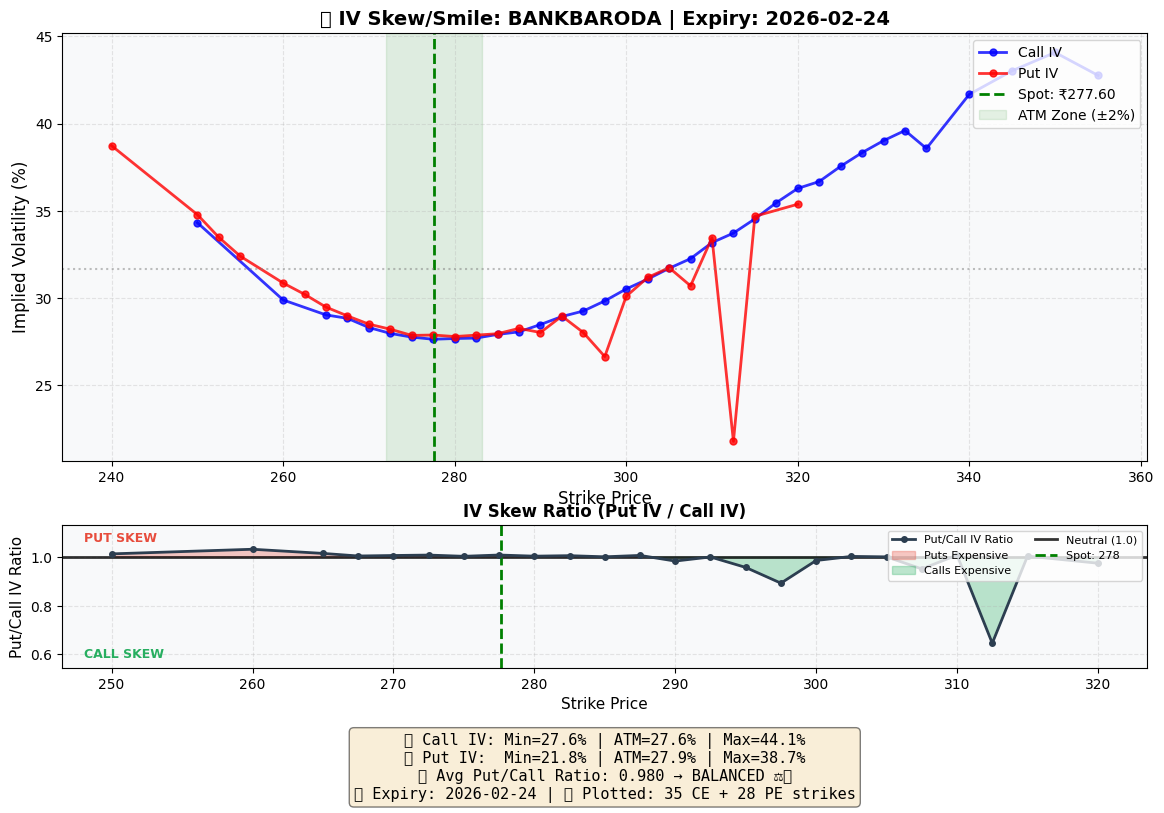

In [121]:
# TEST: Get option chain with IV for BANKBARODA
meta_bankbaroda, chain_bankbaroda = get_option_chain_with_iv('BANKBARODA', oi_filter_pct=0.1)
print(f"\n📋 Metadata: {meta_bankbaroda}")
print(f"Total options: {len(chain_bankbaroda)}")

# Display the chain with IV
if not chain_bankbaroda.empty:
    show_chain(chain_bankbaroda, 'BANKBARODA')
    visualize_iv_skew(chain_bankbaroda, 'BANKBARODA')

In [ ]:
chain.head()

,tradingsymbol,strike,instrument_type,expiry,lot_size,instrument_token,tick_size,segment,ltp,mid_price,oi,volume,bid,ask,bid_qty,ask_qty,iv
0,GOLDM26FEB119500PE,119500.0,PE,2026-02-26,1,141846023,0.5,MCX-OPT,3500.0,3459.00,252.0,1983.0,3415.0,3503.0,1.0,2.0,89.330726
1,GOLDM26FEB120000PE,120000.0,PE,2026-02-26,1,141845767,0.5,MCX-OPT,3508.5,3490.75,2347.0,30844.0,3460.5,3521.0,1.0,1.0,88.401976
2,GOLDM26FEB120500PE,120500.0,PE,2026-02-26,1,141845511,0.5,MCX-OPT,4000.0,3602.00,2.0,3.0,1205.0,5999.0,1.0,1.0,88.288311
3,GOLDM26FEB121000PE,121000.0,PE,2026-02-26,1,141845255,0.5,MCX-OPT,3412.0,3630.00,25.0,50.0,3412.0,3848.0,1.0,2.0,87.303904
4,GOLDM26FEB121500PE,121500.0,PE,2026-02-26,1,141844999,0.5,MCX-OPT,0.0,952.00,0.0,0.0,952.0,0.0,1.0,0.0,54.041505


In [119]:
kite.quote('MCX:GOLDM26FEB119500PE')

{'MCX:GOLDM26FEB119500PE': {'instrument_token': 141846023,
  'timestamp': datetime.datetime(2026, 2, 2, 20, 9),
  'last_trade_time': datetime.datetime(2026, 2, 2, 20, 8, 55),
  'last_price': 3005,
  'last_quantity': 1,
  'buy_quantity': 58,
  'sell_quantity': 81,
  'volume': 2109,
  'average_price': 3492.6,
  'oi': 255,
  'oi_day_high': 265,
  'oi_day_low': 1,
  'net_change': 0,
  'lower_circuit_limit': 500,
  'upper_circuit_limit': 8226,
  'ohlc': {'open': 4000, 'high': 6234, 'low': 1950, 'close': 2005.5},
  'depth': {'buy': [{'price': 2854, 'quantity': 1, 'orders': 1},
    {'price': 2853.5, 'quantity': 4, 'orders': 1},
    {'price': 2850, 'quantity': 1, 'orders': 1},
    {'price': 2800, 'quantity': 2, 'orders': 2},
    {'price': 2705.5, 'quantity': 1, 'orders': 1}],
   'sell': [{'price': 2999.5, 'quantity': 1, 'orders': 1},
    {'price': 3000, 'quantity': 1, 'orders': 1},
    {'price': 3004, 'quantity': 1, 'orders': 1},
    {'price': 3019, 'quantity': 1, 'orders': 1},
    {'price': 3

In [99]:
del chain_goldm

In [104]:
show_chain(chain_goldm, 'GOLDM')


  GOLDM Option Chain - Expiry: 2026-02-26
  Total Options: 954

                                 CALLS (CE)                                  STRIKE                                  PUTS (PE)                                
 CE-BID  CE-ASK  CE-LTP      CE-IV  CE-VOLUME  CE-OI   STRIKE  PE-BID  PE-ASK  PE-OI  PE-VOLUME      PE-IV  PE-LTP
    NaN     NaN     NaN        NaN        NaN    NaN 119500.0  3242.5  3320.0  251.0     2046.0  89.102219  3240.0
    NaN     NaN     NaN        NaN        NaN    NaN 120000.0  3277.0  3300.0 2344.0    31332.0  87.940918  3286.0
    NaN     NaN     NaN        NaN        NaN    NaN 120500.0  1205.0  5999.0    2.0        3.0  89.988309  4000.0
    NaN     NaN     NaN        NaN        NaN    NaN 121000.0  3100.5  3985.0   25.0       50.0  88.116077  3412.0
    NaN     NaN     NaN        NaN        NaN    NaN 121500.0   952.0     0.0    0.0        0.0  55.429624     0.0
    NaN     NaN     NaN        NaN        NaN    NaN 122000.0   701.0     0.0    0.0  

,CE-BID,CE-ASK,CE-LTP,CE-IV,CE-VOLUME,CE-OI,STRIKE,PE-BID,PE-ASK,PE-OI,PE-VOLUME,PE-IV,PE-LTP
0,NaN,NaN,NaN,NaN,NaN,NaN,119500.0,3242.5,3320.0,251.0,2046.0,89.102219,3240.0
1,NaN,NaN,NaN,NaN,NaN,NaN,120000.0,3277.0,3300.0,2344.0,31332.0,87.940918,3286.0
2,NaN,NaN,NaN,NaN,NaN,NaN,120500.0,1205.0,5999.0,2.0,3.0,89.988309,4000.0
3,NaN,NaN,NaN,NaN,NaN,NaN,121000.0,3100.5,3985.0,25.0,50.0,88.116077,3412.0
4,NaN,NaN,NaN,NaN,NaN,NaN,121500.0,952.0,0.0,0.0,0.0,55.429624,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,225.0,0.0,1064.0,64.792882,0.0,0.0,203000.0,NaN,NaN,NaN,NaN,NaN,NaN
575,448.0,0.0,2875.5,73.119301,0.0,2.0,203500.0,NaN,NaN,NaN,NaN,NaN,NaN
576,588.0,0.0,1006.5,77.347825,0.0,0.0,204000.0,NaN,NaN,NaN,NaN,NaN,NaN
577,802.0,1340.0,1183.0,88.032805,2.0,2.0,204500.0,NaN,NaN,NaN,NaN,NaN,NaN


## Testing Option chain


In [116]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_iv_skew(option_chain, basename, spot_price=None, spot_exchange='NSE', 
                      figsize=(14, 10), remove_outliers=True, outlier_iqr_factor=1.5):
    """
    Visualize IV Skew/Smile for an option chain.
    
    Parameters:
    -----------
    option_chain : DataFrame
        Option chain DataFrame with 'iv' column (from calculate_iv_vollib)
    basename : str
        The underlying symbol name (e.g., 'NIFTY', 'ADANIENT')
    spot_price : float, optional
        Spot price to display. If None, will fetch using kite.ltp()
    spot_exchange : str
        Exchange for spot price lookup (default: 'NSE')
    figsize : tuple
        Figure size (width, height)
    remove_outliers : bool
        If True, removes IV outliers using IQR method (default: True)
    outlier_iqr_factor : float
        IQR multiplier for outlier detection (default: 1.5)
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object for further customization if needed
    """
    
    # Validate input
    if option_chain.empty:
        print("❌ Empty option chain provided!")
        return None
    
    if 'iv' not in option_chain.columns:
        print("❌ No 'iv' column found! Run calculate_iv_vollib() first.")
        return None
    
    # ============================================================
    # Data Cleaning: Handle NaN, 0, and invalid IV values
    # ============================================================
    original_count = len(option_chain)
    
    # Step 1: Remove rows with NaN in IV column
    chain_clean = option_chain.dropna(subset=['iv']).copy()
    nan_removed = original_count - len(chain_clean)
    
    # Step 2: Remove rows with IV = 0 (no information)
    zero_count = (chain_clean['iv'] == 0).sum()
    chain_clean = chain_clean[chain_clean['iv'] > 0].copy()
    
    # Step 3: Remove extremely high IV (> 200% is unrealistic for most cases)
    extreme_count = (chain_clean['iv'] >= 200).sum()
    chain_clean = chain_clean[chain_clean['iv'] < 200].copy()
    
    if nan_removed > 0 or zero_count > 0 or extreme_count > 0:
        print(f"🧹 Data Cleaning: Removed {nan_removed} NaN, {zero_count} zero, {extreme_count} extreme (>=200%) IV values")
    
    if chain_clean.empty:
        print("❌ No valid IV data after cleaning!")
        return None
    
    # Get spot price if not provided
    if spot_price is None:
        # Index mappings
        index_mapping = {
            'NIFTY': 'NSE:NIFTY 50',
            'BANKNIFTY': 'NSE:NIFTY BANK',
            'FINNIFTY': 'NSE:NIFTY FIN SERVICE',
            'MIDCPNIFTY': 'NSE:NIFTY MID SELECT'
        }
        
        if basename.upper() in index_mapping:
            spot_symbol = index_mapping[basename.upper()]
        else:
            spot_symbol = f"{spot_exchange}:{basename}"
        
        try:
            ltp_data = kite.ltp(spot_symbol)
            spot_price = ltp_data[spot_symbol]['last_price']
            print(f"📍 Spot Price for {basename}: ₹{spot_price:,.2f}")
        except Exception as e:
            print(f"⚠️ Could not fetch spot price: {e}")
            spot_price = None
    
    # Separate CE and PE data (column name is 'instrument_type' in our chain)
    type_col = 'option_type' if 'option_type' in chain_clean.columns else 'instrument_type'
    ce_data = chain_clean[chain_clean[type_col] == 'CE'].copy()
    pe_data = chain_clean[chain_clean[type_col] == 'PE'].copy()
    
    # ============================================================
    # Outlier Removal using IQR method (separately for CE and PE)
    # ============================================================
    if remove_outliers:
        def remove_iv_outliers(df, label):
            if df.empty:
                return df
            Q1 = df['iv'].quantile(0.25)
            Q3 = df['iv'].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - outlier_iqr_factor * IQR
            upper_bound = Q3 + outlier_iqr_factor * IQR
            
            before = len(df)
            df_clean = df[(df['iv'] >= lower_bound) & (df['iv'] <= upper_bound)].copy()
            removed = before - len(df_clean)
            
            if removed > 0:
                print(f"   {label}: Removed {removed} outliers (IQR bounds: {lower_bound:.1f}% - {upper_bound:.1f}%)")
            return df_clean
        
        print(f"🔍 Removing IV outliers (IQR × {outlier_iqr_factor})...")
        ce_data = remove_iv_outliers(ce_data, "CE")
        pe_data = remove_iv_outliers(pe_data, "PE")
    
    # Sort by strike
    ce_data = ce_data.sort_values('strike')
    pe_data = pe_data.sort_values('strike')
    
    if ce_data.empty and pe_data.empty:
        print("❌ No valid IV data to plot after outlier removal!")
        return None
    
    # Calculate final counts
    total_strikes_plotted = len(ce_data['strike'].unique()) + len(pe_data['strike'].unique())
    print(f"📊 Plotting {len(ce_data)} CE and {len(pe_data)} PE options ({total_strikes_plotted} total strikes)")
    
    # Get unique expiries
    expiries = chain_clean['expiry'].unique()
    expiry_str = str(expiries[0])[:10] if len(expiries) > 0 else 'Unknown'
    
    # Create figure with GridSpec for better layout
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 1, height_ratios=[3, 1, 0.5], hspace=0.3)
    
    # ===== TOP PLOT: IV Skew/Smile =====
    ax1 = fig.add_subplot(gs[0])
    
    # Plot CE IV
    if not ce_data.empty:
        ax1.plot(ce_data['strike'], ce_data['iv'], 
                 'b-o', label='Call IV', linewidth=2, markersize=5, alpha=0.8)
    
    # Plot PE IV
    if not pe_data.empty:
        ax1.plot(pe_data['strike'], pe_data['iv'], 
                 'r-o', label='Put IV', linewidth=2, markersize=5, alpha=0.8)
    
    # Add spot price line
    if spot_price is not None:
        ax1.axvline(x=spot_price, color='green', linestyle='--', linewidth=2, 
                    label=f'Spot: ₹{spot_price:,.2f}')
        
        # Shade ATM region (±2% of spot)
        atm_range = spot_price * 0.02
        ax1.axvspan(spot_price - atm_range, spot_price + atm_range, 
                    alpha=0.1, color='green', label='ATM Zone (±2%)')
    
    # Styling
    ax1.set_xlabel('Strike Price', fontsize=12)
    ax1.set_ylabel('Implied Volatility (%)', fontsize=12)
    ax1.set_title(f'📊 IV Skew/Smile: {basename} | Expiry: {expiry_str}', 
                  fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_facecolor('#f8f9fa')
    
    # Add horizontal lines for reference
    if not ce_data.empty and not pe_data.empty:
        avg_iv = (ce_data['iv'].mean() + pe_data['iv'].mean()) / 2
        ax1.axhline(y=avg_iv, color='gray', linestyle=':', alpha=0.5, 
                    label=f'Avg IV: {avg_iv:.1f}%')
    
    # ===== MIDDLE PLOT: Put/Call IV Ratio (Line Graph with Area Fill) =====
    ax2 = fig.add_subplot(gs[1])
    
    # Merge CE and PE data on strike to calculate ratio
    if not ce_data.empty and not pe_data.empty:
        merged = ce_data[['strike', 'iv']].merge(
            pe_data[['strike', 'iv']], 
            on='strike', 
            suffixes=('_ce', '_pe')
        )
        
        if not merged.empty:
            # Calculate Put/Call IV Ratio
            merged['iv_ratio'] = merged['iv_pe'] / merged['iv_ce']
            merged = merged.sort_values('strike')
            
            strikes = merged['strike'].values
            ratios = merged['iv_ratio'].values
            
            # Plot the ratio line
            ax2.plot(strikes, ratios, 'b-o', linewidth=2, markersize=4, 
                     label='Put/Call IV Ratio', color='#2c3e50', zorder=3)
            
            # Fill area above 1 (puts expensive) in red
            ax2.fill_between(strikes, 1.0, ratios, where=(ratios > 1.0), 
                            interpolate=True, alpha=0.3, color='#e74c3c', 
                            label='Puts Expensive')
            
            # Fill area below 1 (calls expensive) in green  
            ax2.fill_between(strikes, ratios, 1.0, where=(ratios < 1.0),
                            interpolate=True, alpha=0.3, color='#27ae60',
                            label='Calls Expensive')
            
            # Add horizontal reference line at ratio = 1
            ax2.axhline(y=1.0, color='black', linestyle='-', linewidth=2, alpha=0.8, label='Neutral (1.0)')
            
            # Add spot price line
            if spot_price is not None:
                ax2.axvline(x=spot_price, color='green', linestyle='--', linewidth=2, 
                           label=f'Spot: {spot_price:,.0f}')
            
            # Labels and styling
            ax2.set_xlabel('Strike Price', fontsize=11)
            ax2.set_ylabel('Put/Call IV Ratio', fontsize=11)
            ax2.set_title('IV Skew Ratio (Put IV / Call IV)', fontsize=12, fontweight='bold')
            ax2.legend(loc='upper right', fontsize=8, ncol=2)
            ax2.grid(True, alpha=0.3, linestyle='--')
            ax2.set_facecolor('#f8f9fa')
            
            # Set y-axis limits with some padding
            y_min = max(0.5, ratios.min() - 0.1)
            y_max = min(2.5, ratios.max() + 0.1)
            ax2.set_ylim(y_min, y_max)
            
            # Add secondary y-axis labels for interpretation
            ax2.text(0.02, 0.95, 'PUT SKEW', transform=ax2.transAxes, fontsize=9, 
                    color='#e74c3c', fontweight='bold', va='top')
            ax2.text(0.02, 0.05, 'CALL SKEW', transform=ax2.transAxes, fontsize=9,
                    color='#27ae60', fontweight='bold', va='bottom')
    else:
        ax2.text(0.5, 0.5, 'Insufficient data for ratio calculation', 
                 ha='center', va='center', transform=ax2.transAxes)
        merged = None
    
    # ===== BOTTOM: Summary Statistics =====
    ax3 = fig.add_subplot(gs[2])
    ax3.axis('off')
    
    # Calculate summary stats
    stats_text = []
    
    if not ce_data.empty:
        ce_atm = ce_data.iloc[(ce_data['strike'] - (spot_price or ce_data['strike'].median())).abs().argsort()[:1]]
        ce_atm_iv = ce_atm['iv'].values[0] if not ce_atm.empty else 'N/A'
        stats_text.append(f"📞 Call IV: Min={ce_data['iv'].min():.1f}% | ATM={ce_atm_iv:.1f}% | Max={ce_data['iv'].max():.1f}%")
    
    if not pe_data.empty:
        pe_atm = pe_data.iloc[(pe_data['strike'] - (spot_price or pe_data['strike'].median())).abs().argsort()[:1]]
        pe_atm_iv = pe_atm['iv'].values[0] if not pe_atm.empty else 'N/A'
        stats_text.append(f"📱 Put IV:  Min={pe_data['iv'].min():.1f}% | ATM={pe_atm_iv:.1f}% | Max={pe_data['iv'].max():.1f}%")
    
    if merged is not None and not merged.empty:
        avg_ratio = merged['iv_ratio'].mean()
        skew_type = "PUT SKEW 📉" if avg_ratio > 1.05 else "CALL SKEW 📈" if avg_ratio < 0.95 else "BALANCED ⚖️"
        stats_text.append(f"📊 Avg Put/Call Ratio: {avg_ratio:.3f} → {skew_type}")
    
    # Use the FILTERED counts, not original
    stats_text.append(f"📅 Expiry: {expiry_str} | 🎯 Plotted: {len(ce_data)} CE + {len(pe_data)} PE strikes")
    
    ax3.text(0.5, 0.5, '\n'.join(stats_text), 
             ha='center', va='center', transform=ax3.transAxes,
             fontsize=11, fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    return fig

print("✅ IV Skew Visualizer loaded!")
print("📌 Usage: visualize_iv_skew(chain, 'ADANIENT')")
print("   - chain: DataFrame with 'iv' column from calculate_iv_vollib()")
print("   - Automatically removes NaN, 0, and extreme (>200%) IV values")
print("   - Removes IV outliers using IQR method (configurable)")
print("   - Shows IV smile/skew for CE and PE")
print("   - Displays spot price as vertical line")
print("   - Shows Put/Call IV ratio at each strike")

✅ IV Skew Visualizer loaded!
📌 Usage: visualize_iv_skew(chain, 'ADANIENT')
   - chain: DataFrame with 'iv' column from calculate_iv_vollib()
   - Automatically removes NaN, 0, and extreme (>200%) IV values
   - Removes IV outliers using IQR method (configurable)
   - Shows IV smile/skew for CE and PE
   - Displays spot price as vertical line
   - Shows Put/Call IV ratio at each strike


🧹 Data Cleaning: Removed 0 NaN, 0 zero, 1 extreme (>=200%) IV values
⚠️ Could not fetch spot price: 'NSE:GOLDM'
🔍 Removing IV outliers (IQR × 1.5)...
   CE: Removed 77 outliers (IQR bounds: 62.4% - 117.9%)
   PE: Removed 3 outliers (IQR bounds: 10.8% - 123.2%)
📊 Plotting 489 CE and 432 PE options (921 total strikes)


C:\Users\sathy\AppData\Local\Temp\ipykernel_10200\4110604974.py:196: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(strikes, ratios, 'b-o', linewidth=2, markersize=4,
C:\Users\sathy\AppData\Local\Temp\ipykernel_10200\4110604974.py:270: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\sathy\.virtualenvs\Project_Algoarms-ktqofeKa\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\sathy\.virtualenvs\Project_Algoarms-ktqofeKa\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128222 (\N{TELEPHONE RECEIVER}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\sathy\.virtualenvs\Project_Algoarms-ktqof

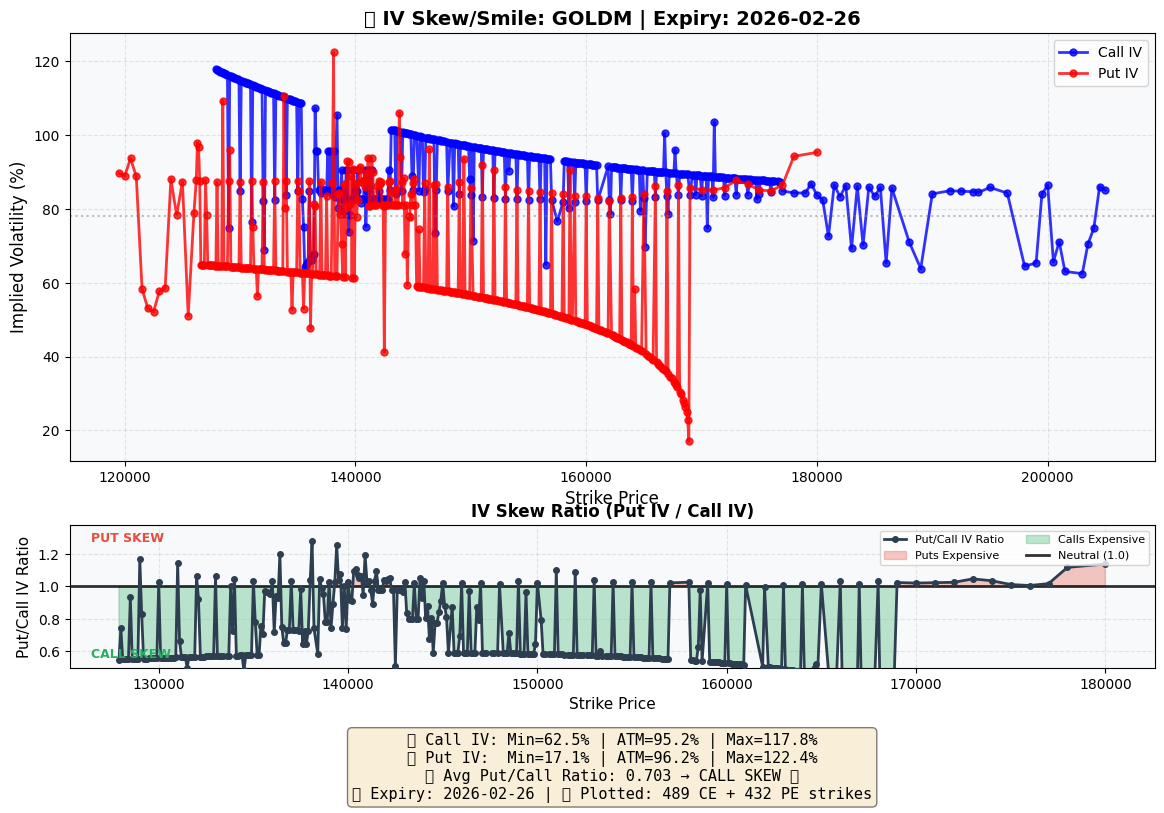

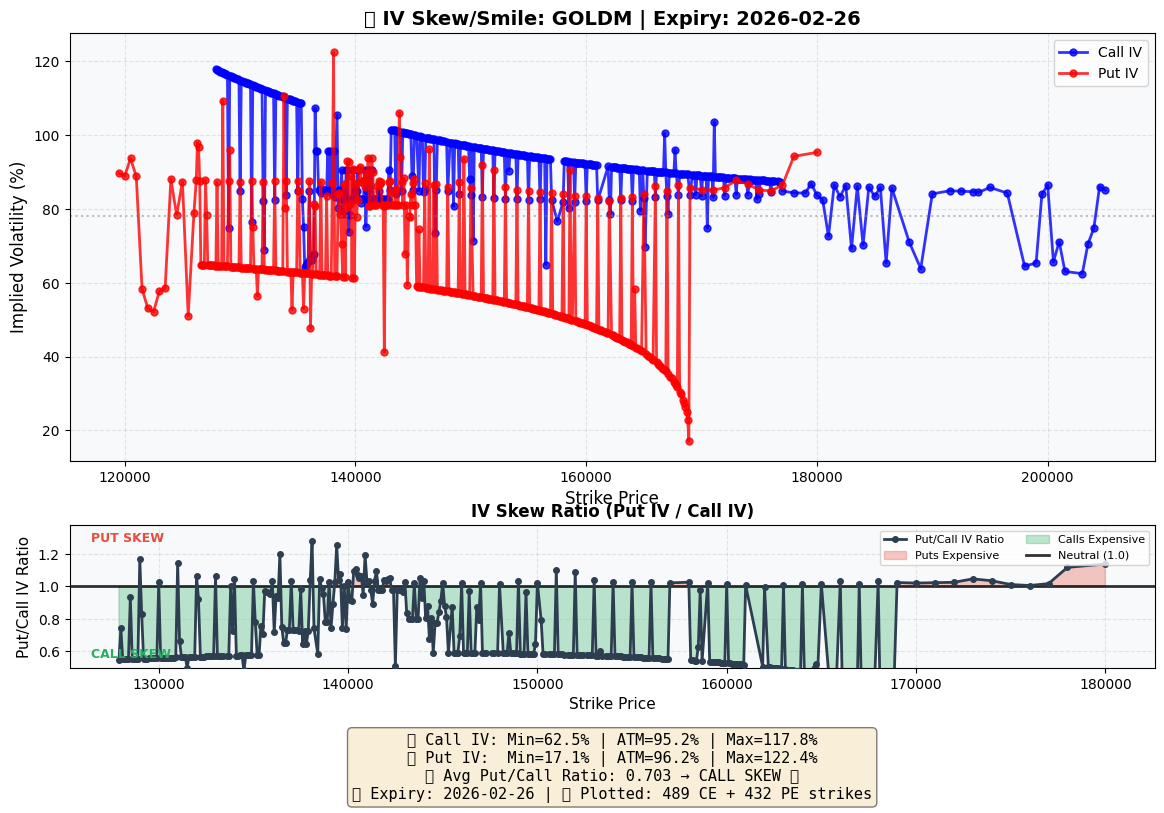

In [117]:
visualize_iv_skew(chain_goldm, 'GOLDM')


📊 Building Option Chain with IV for IDEA
📅 Using nearest expiry: 2026-02-24
📊 Processing 12 CE options in chunks of 250...
  Chunk 1/1: Fetching CE quotes 1-12...
  ✅ Retrieved 12 quotes
📊 Processing 10 PE options in chunks of 250...
  Chunk 1/1: Fetching PE quotes 1-10...
  ✅ Retrieved 10 quotes
✅ Enrichment complete: 22 options with market data
   📌 mid_price column added (bid/ask midpoint for accurate IV calculation)
📌 Using 'mid_price' for IV calculation (bid/ask midpoint is more accurate than stale LTP)
📊 Spot Price for IDEA: ₹10.81 (from NSE:IDEA)
📅 Expiry: 2026-02-24 | Time to Expiry: 0.060475 years (22.07 days)
✅ IV calculated for 16/22 options (using mid_price)
   Average IV: 65.38%
   IV Range: 49.80% - 124.27%

✅ Option chain ready with 22 options

📋 Metadata: {'basename': 'IDEA', 'exchange': 'NFO', 'segment': 'NFO-OPT', 'expiry': Timestamp('2026-02-24 00:00:00'), 'tick_size': 0.009999999776482582, 'lot_size': 5939}
📍 Spot Price for IDEA: ₹10.81


C:\Users\sathy\AppData\Local\Temp\ipykernel_10200\663000863.py:142: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(strikes, ratios, 'b-o', linewidth=2, markersize=4,
C:\Users\sathy\AppData\Local\Temp\ipykernel_10200\663000863.py:214: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\sathy\.virtualenvs\Project_Algoarms-ktqofeKa\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\sathy\.virtualenvs\Project_Algoarms-ktqofeKa\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128222 (\N{TELEPHONE RECEIVER}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\sathy\.virtualenvs\Project_Algoarms-ktqofeK

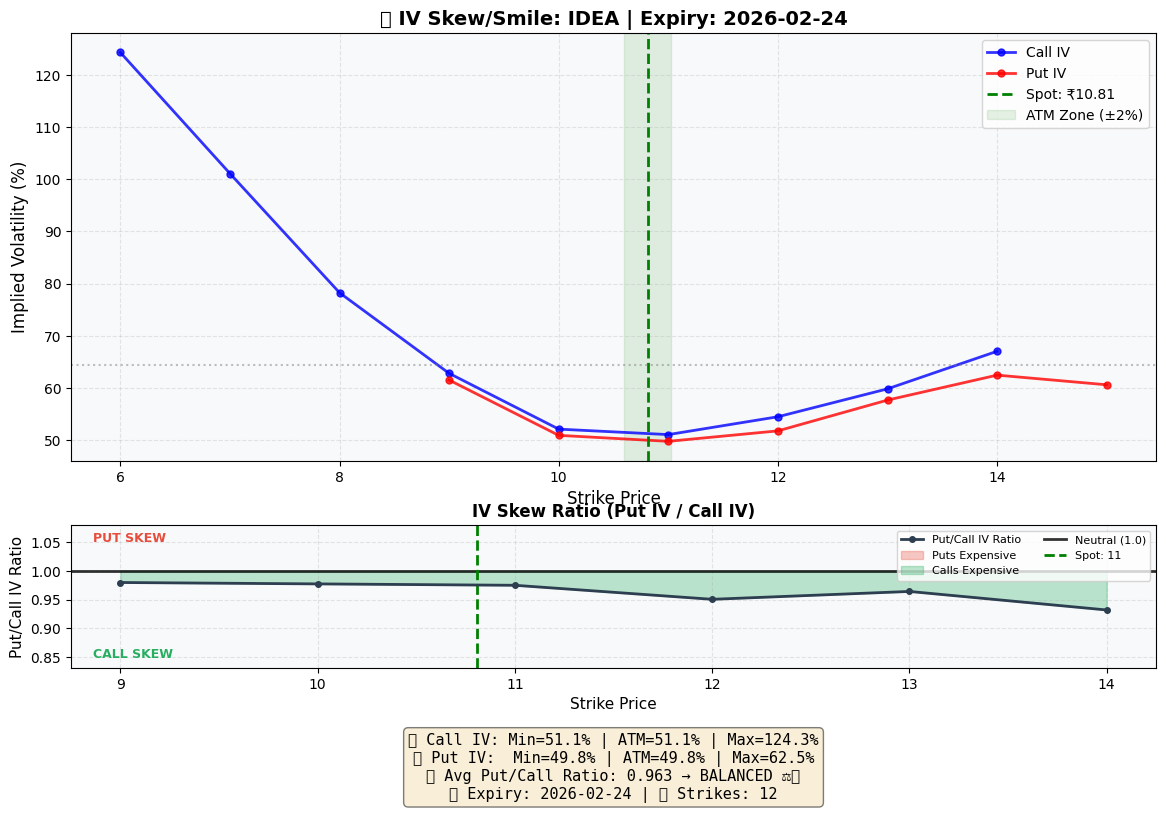

In [35]:
# TEST: Visualize IV Skew for IDEA
meta_idea, chain_idea = get_option_chain_with_iv('IDEA')
print(f"\n📋 Metadata: {meta_idea}")

# Display the IV skew visualization
if not chain_idea.empty and 'iv' in chain_idea.columns:
    visualize_iv_skew(chain_idea, 'IDEA')


📊 Building Option Chain with IV for ADANIENT
📅 Using nearest expiry: 2026-02-24
📊 Processing 48 CE options in chunks of 250...
  Chunk 1/1: Fetching CE quotes 1-48...
  ✅ Retrieved 48 quotes
📊 Processing 53 PE options in chunks of 250...
  Chunk 1/1: Fetching PE quotes 1-53...
  ✅ Retrieved 53 quotes
✅ Enrichment complete: 101 options with market data
📊 Spot Price for ADANIENT: ₹1,942.80 (from NSE:ADANIENT)
📅 Expiry: 2026-02-24 | Time to Expiry: 0.062857 years (22.94 days)
✅ IV calculated for 82/101 options
   Average IV: 53.36%
   IV Range: 28.91% - 117.36%

✅ Option chain ready with 101 options
📍 Spot Price for ADANIENT: ₹1,942.80


C:\Users\sathy\AppData\Local\Temp\ipykernel_15080\663000863.py:142: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(strikes, ratios, 'b-o', linewidth=2, markersize=4,
C:\Users\sathy\AppData\Local\Temp\ipykernel_15080\663000863.py:214: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\sathy\.virtualenvs\Project_Algoarms-ktqofeKa\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\sathy\.virtualenvs\Project_Algoarms-ktqofeKa\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128222 (\N{TELEPHONE RECEIVER}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\sathy\.virtualenvs\Project_Algoarms-ktqofeK

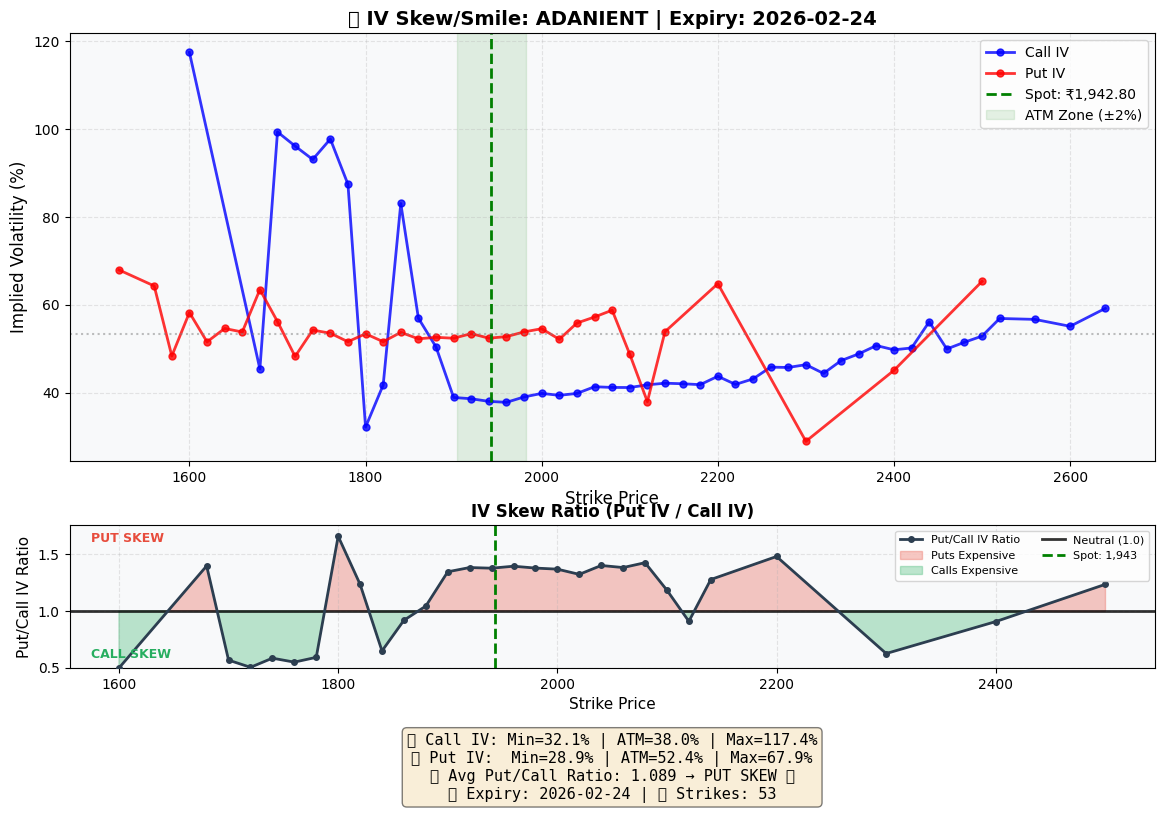


📊 Building Option Chain with IV for NIFTY
📅 Using nearest expiry: 2026-02-03
📊 Processing 97 CE options in chunks of 250...
  Chunk 1/1: Fetching CE quotes 1-97...
  ✅ Retrieved 97 quotes
📊 Processing 97 PE options in chunks of 250...
  Chunk 1/1: Fetching PE quotes 1-97...
  ✅ Retrieved 97 quotes
✅ Enrichment complete: 194 options with market data
📊 Spot Price for NIFTY: ₹24,825.45 (from NSE:NIFTY 50)
📅 Expiry: 2026-02-03 | Time to Expiry: 0.005362 years (1.96 days)
✅ IV calculated for 149/194 options
   Average IV: 44.99%
   IV Range: 8.90% - 143.48%

✅ Option chain ready with 194 options
📍 Spot Price for NIFTY: ₹24,825.45


C:\Users\sathy\AppData\Local\Temp\ipykernel_15080\663000863.py:142: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(strikes, ratios, 'b-o', linewidth=2, markersize=4,
C:\Users\sathy\AppData\Local\Temp\ipykernel_15080\663000863.py:214: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\sathy\.virtualenvs\Project_Algoarms-ktqofeKa\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\sathy\.virtualenvs\Project_Algoarms-ktqofeKa\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128222 (\N{TELEPHONE RECEIVER}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\sathy\.virtualenvs\Project_Algoarms-ktqofeK

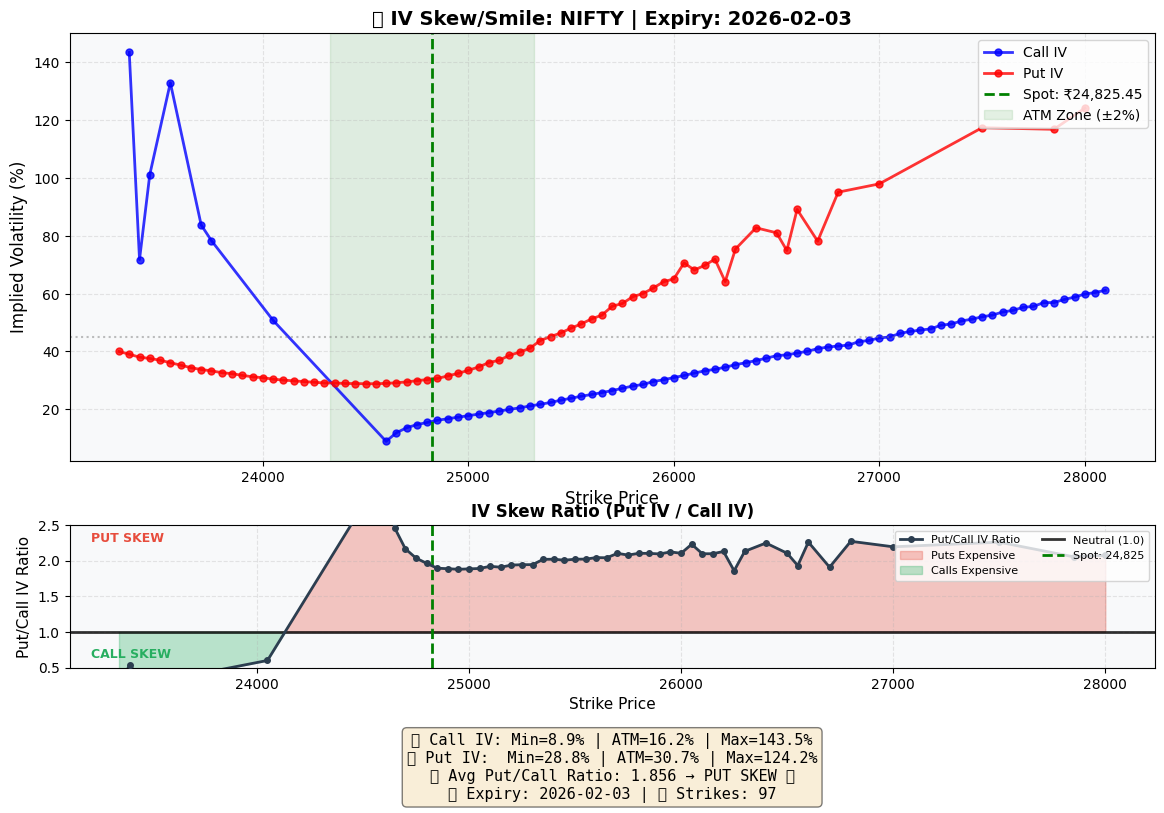

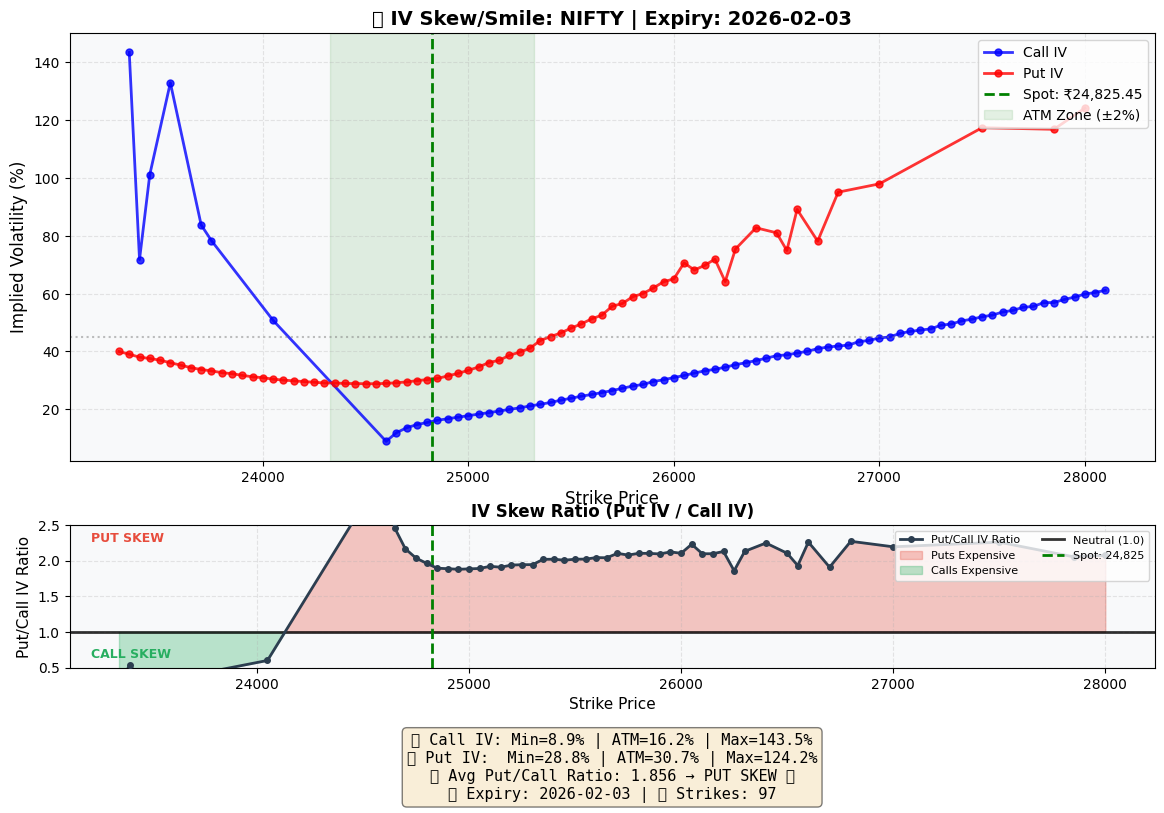

In [ ]:
# Get chain with IV and visualize
meta, chain = get_option_chain_with_iv('ADANIENT')
print(f"📋 Metadata: {meta}")
visualize_iv_skew(chain, 'ADANIENT')

# Or for indices
meta, chain = get_option_chain_with_iv('NIFTY')
print(f"📋 Metadata: {meta}")
visualize_iv_skew(chain, 'NIFTY')


📊 Building Option Chain with IV for IDEA
📅 Using nearest expiry: 2026-02-24
📊 Processing 12 CE options in chunks of 250...
  Chunk 1/1: Fetching CE quotes 1-12...
  ✅ Retrieved 12 quotes
📊 Processing 10 PE options in chunks of 250...
  Chunk 1/1: Fetching PE quotes 1-10...
  ✅ Retrieved 10 quotes
✅ Enrichment complete: 22 options with market data
   📌 mid_price column added (bid/ask midpoint for accurate IV calculation)
📌 Using 'mid_price' for IV calculation (bid/ask midpoint is more accurate than stale LTP)
📊 Spot Price for IDEA: ₹10.81 (from NSE:IDEA)
📅 Expiry: 2026-02-24 | Time to Expiry: 0.060475 years (22.07 days)
✅ IV calculated for 16/22 options (using mid_price)
   Average IV: 65.38%
   IV Range: 49.80% - 124.28%

✅ Option chain ready with 22 options
📋 Metadata: {'basename': 'IDEA', 'exchange': 'NFO', 'segment': 'NFO-OPT', 'expiry': Timestamp('2026-02-24 00:00:00'), 'tick_size': 0.009999999776482582, 'lot_size': 5939}
📍 Spot Price for IDEA: ₹10.81


C:\Users\sathy\AppData\Local\Temp\ipykernel_10200\663000863.py:142: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(strikes, ratios, 'b-o', linewidth=2, markersize=4,
C:\Users\sathy\AppData\Local\Temp\ipykernel_10200\663000863.py:214: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\sathy\.virtualenvs\Project_Algoarms-ktqofeKa\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\sathy\.virtualenvs\Project_Algoarms-ktqofeKa\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128222 (\N{TELEPHONE RECEIVER}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\sathy\.virtualenvs\Project_Algoarms-ktqofeK

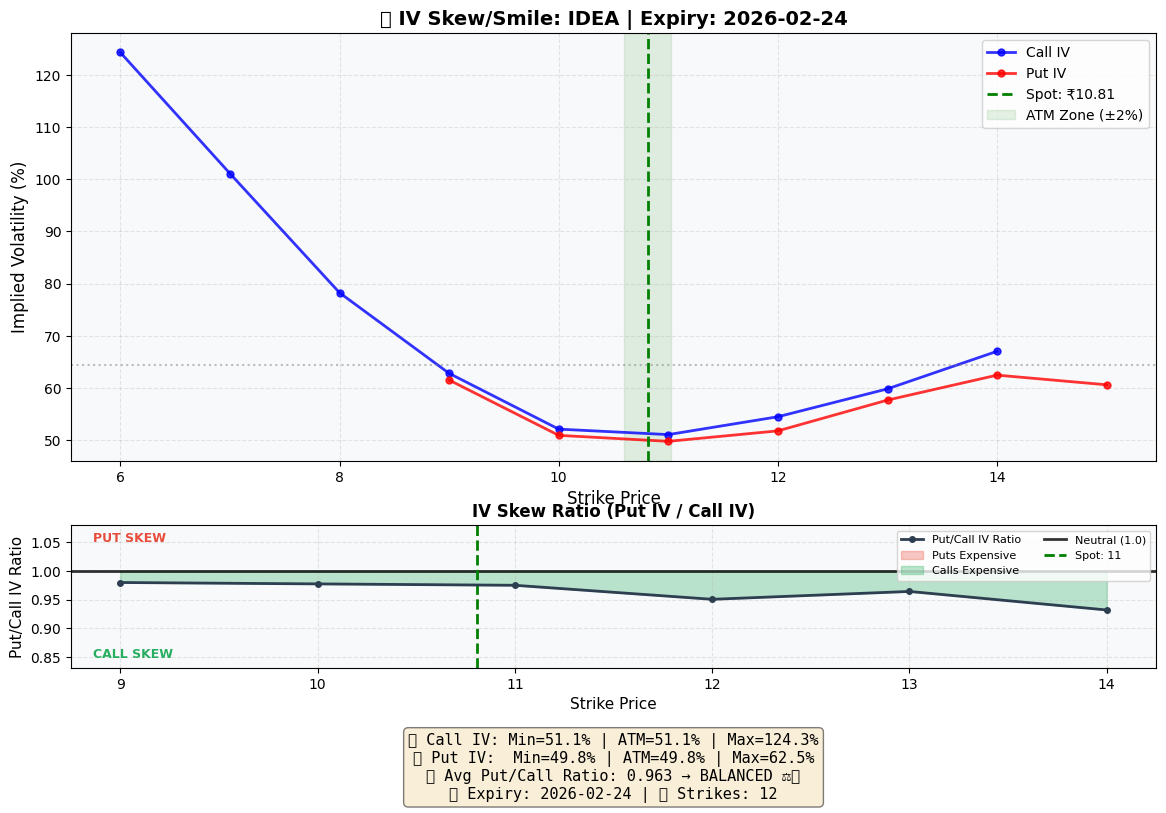

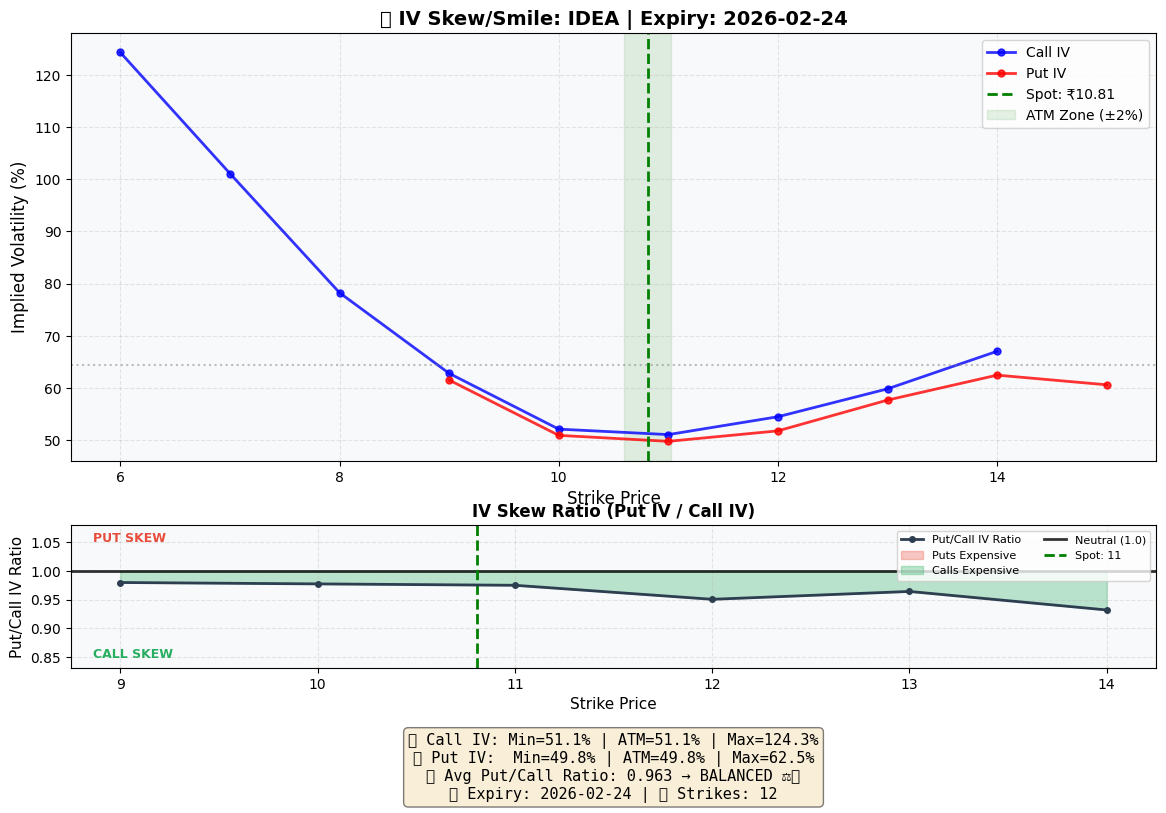

In [36]:
# Get chain with IV and visualize
meta, chain = get_option_chain_with_iv('IDEA')
print(f"📋 Metadata: {meta}")
visualize_iv_skew(chain, 'IDEA')


📊 Building Option Chain with IV for NIFTY
📅 Using nearest expiry: 2026-02-03
📊 Processing 101 CE options in chunks of 250...
  Chunk 1/1: Fetching CE quotes 1-101...
  ✅ Retrieved 101 quotes
📊 Processing 101 PE options in chunks of 250...
  Chunk 1/1: Fetching PE quotes 1-101...
  ✅ Retrieved 101 quotes
✅ Enrichment complete: 202 options with market data
   📌 mid_price column added (bid/ask midpoint for accurate IV calculation)
📌 Using 'mid_price' for IV calculation (bid/ask midpoint is more accurate than stale LTP)
📊 Spot Price for NIFTY: ₹25,088.40 (from NSE:NIFTY 50)
📅 Expiry: 2026-02-03 | Time to Expiry: 0.002980 years (1.09 days)
✅ IV calculated for 167/202 options (using mid_price)
   Average IV: 48.62%
   IV Range: 8.81% - 168.28%

✅ Option chain ready with 202 options

📋 Metadata: {'basename': 'NIFTY', 'exchange': 'NFO', 'segment': 'NFO-OPT', 'expiry': Timestamp('2026-02-03 00:00:00'), 'tick_size': 0.05000000074505806, 'lot_size': 65}
📍 Spot Price for NIFTY: ₹25,088.40


C:\Users\sathy\AppData\Local\Temp\ipykernel_10200\663000863.py:142: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(strikes, ratios, 'b-o', linewidth=2, markersize=4,
C:\Users\sathy\AppData\Local\Temp\ipykernel_10200\663000863.py:214: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\sathy\.virtualenvs\Project_Algoarms-ktqofeKa\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\sathy\.virtualenvs\Project_Algoarms-ktqofeKa\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128222 (\N{TELEPHONE RECEIVER}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\sathy\.virtualenvs\Project_Algoarms-ktqofeK

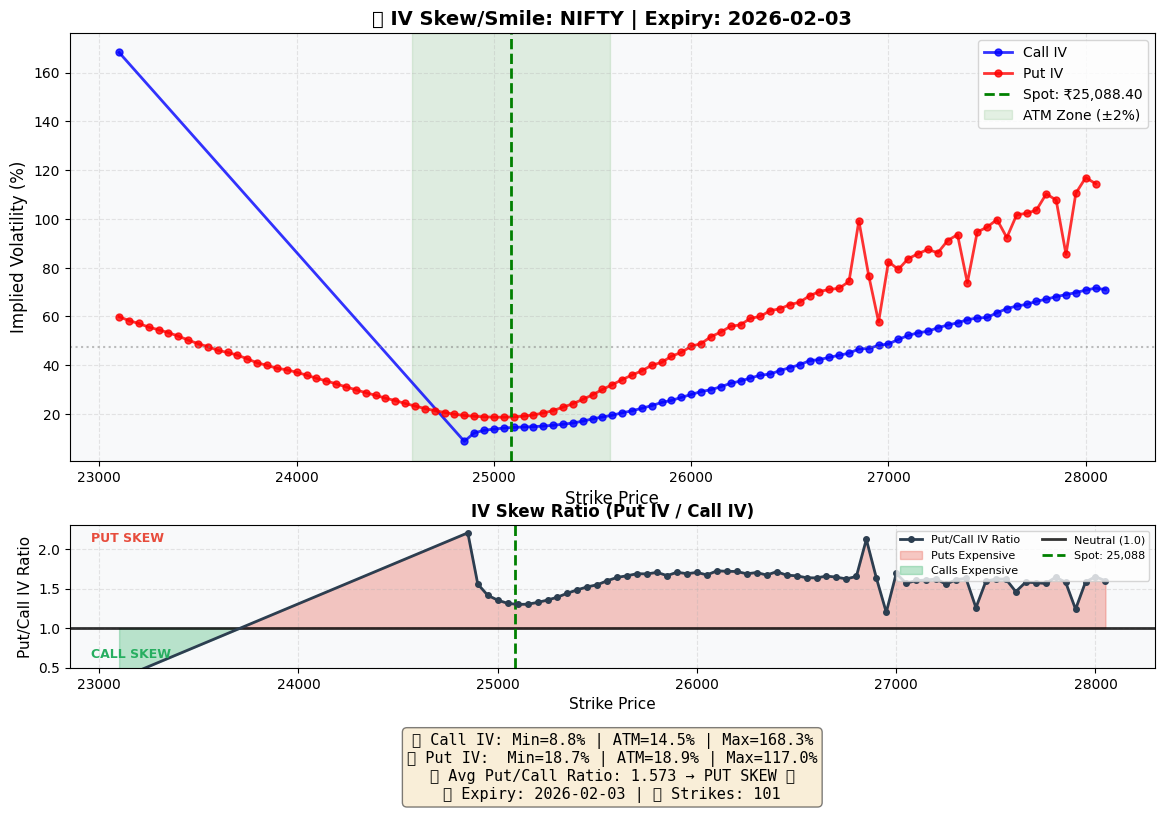

In [37]:
# TEST: Visualize IV Skew for NIFTY (Index)
meta_nifty_viz, chain_nifty_viz = get_option_chain_with_iv('NIFTY')
print(f"\n📋 Metadata: {meta_nifty_viz}")

# Display the IV skew visualization for NIFTY
if not chain_nifty_viz.empty and 'iv' in chain_nifty_viz.columns:
    visualize_iv_skew(chain_nifty_viz, 'NIFTY')

In [ ]:
# Method 1: Full workflow (recommended) - now returns (metadata, chain)
meta, chain = get_option_chain_with_iv('ADANIENT')
meta, chain = get_option_chain_with_iv('NIFTY', expiry='2026-02-06')

# Method 2: Add IV to existing enriched chain  
meta, chain = build_option_chain('RELIANCE', enrich=True)
chain = calculate_iv_vollib(chain, metadata=meta)

# Display with professional format
show_chain(chain, 'ADANIENT')


📊 Building Option Chain with IV for ADANIENT
📅 Using nearest expiry: 2026-02-24
📊 Processing 48 CE options in chunks of 250...
  Chunk 1/1: Fetching CE quotes 1-48...
  ✅ Retrieved 48 quotes
📊 Processing 53 PE options in chunks of 250...
  Chunk 1/1: Fetching PE quotes 1-53...
  ✅ Retrieved 53 quotes
✅ Enrichment complete: 101 options with market data
📊 Spot Price for ADANIENT: ₹1,942.80 (from NSE:ADANIENT)
📅 Expiry: 2026-02-24 | Time to Expiry: 0.062857 years (22.94 days)
✅ IV calculated for 82/101 options
   Average IV: 53.36%
   IV Range: 28.91% - 117.36%

✅ Option chain ready with 101 options

📊 Building Option Chain with IV for NIFTY
⚠️ No options found for NIFTY expiring 2026-02-06 on NFO
❌ Failed to build option chain for NIFTY
📅 Using nearest expiry: 2026-02-24
📊 Processing 57 CE options in chunks of 250...
  Chunk 1/1: Fetching CE quotes 1-57...
  ✅ Retrieved 57 quotes
📊 Processing 53 PE options in chunks of 250...
  Chunk 1/1: Fetching PE quotes 1-53...
  ✅ Retrieved 53 quot

,CE-BID,CE-ASK,CE-LTP,CE-IV,CE-VOLUME,CE-OI,STRIKE,PE-BID,PE-ASK,PE-OI,PE-VOLUME,PE-IV,PE-LTP
0,201.800003,232.899994,198.300003,0.000000,9000.0,9000.0,1140.0,1.800000,2.250000,262500.0,218000.0,38.985196,1.850000
1,182.050003,201.750000,0.000000,0.000000,0.0,0.0,1160.0,2.400000,2.800000,110000.0,113000.0,37.881345,2.500000
2,163.250000,182.250000,0.000000,0.000000,0.0,0.0,1180.0,3.050000,3.300000,127000.0,211500.0,36.110343,3.100000
3,144.100006,150.449997,157.199997,31.561555,9500.0,1020500.0,1200.0,4.100000,4.300000,1134500.0,1034000.0,35.043279,4.200000
4,124.650002,133.250000,135.500000,22.445476,13000.0,72000.0,1220.0,5.200000,6.200000,584000.0,323500.0,33.271963,5.250000
5,104.599998,126.800003,0.000000,0.000000,0.0,0.0,1240.0,7.050000,7.300000,820500.0,739500.0,32.428531,7.250000
6,91.650002,95.949997,89.000000,0.000000,5500.0,7500.0,1260.0,9.500000,9.800000,871500.0,1290500.0,31.462516,9.800000
7,79.050003,103.650002,132.300003,63.698710,0.0,2000.0,1270.0,10.000000,11.350000,319500.0,532500.0,30.366960,10.800000
8,74.599998,78.000000,75.000000,0.000000,29000.0,29500.0,1280.0,12.500000,12.800000,517500.0,1518000.0,30.056297,12.700000
9,65.050003,79.099998,85.000000,34.397272,1500.0,1000.0,1290.0,14.600000,15.100000,240500.0,549000.0,29.870832,15.000000


In [ ]:
# Calculate IV for the existing 'chain' dataframe
# Using the global 'chain' variable from previous generation

if 'chain' in locals() and not chain.empty and 'symbol' in locals():
    print(f"Running IV Calculation for symbol: {symbol}...")
    
    # 1. Identify Expiry and Exchange from the chain data itself
    chain_expiry = chain['expiry'].iloc[0]
    exchange = chain['exchange'].iloc[0] if 'exchange' in chain.columns else 'NFO'
    
    print(f"   Expiry: {chain_expiry} | Exchange: {exchange}")

    # 1.5 Ensure Market Data (LTP) is present
    if 'ltp' not in chain.columns:
        print("⚠️ Market data (LTP) missing from chain. Fetching quotes now...")
        chain = enrich_with_market_data(kite, chain)
        if 'ltp' not in chain.columns:
             print("❌ Failed to fetch market data. Aborting IV calculation.")
             # Stop usage of chain here if critical
    
    # 2. Select Source DataFrame for Future Price lookup
    # (MCX futures are in df_mcx, NFO futures in df_all)
    source_df = None
    if exchange == 'MCX' and 'df_mcx' in globals():
        source_df = df_mcx
    elif 'df_all' in globals():
        source_df = df_all
        
    # 3. Fetch Underlying LTP (Spot or Future)
    underlying_ltp = get_underlying_ltp(kite, symbol, chain_expiry, source_df)
    
    if underlying_ltp > 0 and 'ltp' in chain.columns:
        # 4. Apply Black-Scholes IV Calculation
        chain = add_iv_columns(chain, underlying_ltp)
        print(f"✅ IV Calculated successfully! Underlying Ref Price: {underlying_ltp}")
        
        # 5. Display ATM Options (formatted)
        # Find ATM by smallest distance to underlying price
        chain['diff_pct'] = abs(chain['strike'] - underlying_ltp) / underlying_ltp
        atm_view = chain.sort_values('diff_pct').head(10).sort_values('strike')
        
        cols = ['tradingsymbol', 'strike', 'instrument_type', 'ltp', 'iv', 'oi', 'volume']
        display_cols = [c for c in cols if c in chain.columns]
        
        print("\n📊 Option Chain with IV (ATM View):")
        print(atm_view[display_cols].to_string(index=False))
        
    else:
        print(f"❌ Failed to get Underlying LTP or Market Data. Cannot calculate IV.")
else:
    print("❌ 'chain' dataframe or 'symbol' variable is missing. Please run the chain generation cell above.")

## 🧠 Memory Usage Monitoring

In [15]:
import psutil
import gc
import sys

def get_memory_usage():
    """
    Display comprehensive memory usage statistics
    Automatically detects all pandas DataFrames and large dictionaries in globals()
    """
    # System Memory
    mem = psutil.virtual_memory()
    
    # Python Process Memory
    process = psutil.Process()
    process_mem = process.memory_info()
    
    print("=" * 80)
    print("💾 SYSTEM MEMORY")
    print("=" * 80)
    print(f"Total RAM:        {mem.total / (1024**3):.2f} GB")
    print(f"Available:        {mem.available / (1024**3):.2f} GB")
    print(f"Used:             {mem.used / (1024**3):.2f} GB ({mem.percent}%)")
    print(f"Free:             {mem.free / (1024**3):.2f} GB")
    
    print("\n" + "=" * 80)
    print("🐍 PYTHON PROCESS MEMORY")
    print("=" * 80)
    print(f"RSS (Resident):   {process_mem.rss / (1024**3):.2f} GB")
    print(f"VMS (Virtual):    {process_mem.vms / (1024**3):.2f} GB")
    
    # AUTO-DETECT DataFrames and Dictionaries from globals()
    print("\n" + "=" * 80)
    print("📊 DATAFRAME & DICTIONARY MEMORY USAGE (Auto-detected)")
    print("=" * 80)
    
    # Collect all DataFrames and large dictionaries
    dataframes = []
    dictionaries = []
    
    for name, obj in globals().items():
        # Skip private/system variables and modules
        if name.startswith('_') or name in ['In', 'Out', 'get_ipython', 'exit', 'quit']:
            continue
            
        if isinstance(obj, pd.DataFrame):
            mem_usage = obj.memory_usage(deep=True).sum() / (1024**2)
            dataframes.append((name, obj, mem_usage))
        elif isinstance(obj, dict) and sys.getsizeof(obj) > 1024:  # Only dicts > 1KB
            mem_usage = sys.getsizeof(obj) / (1024**2)
            dictionaries.append((name, obj, mem_usage))
    
    # Sort by memory usage (largest first)
    dataframes.sort(key=lambda x: x[2], reverse=True)
    dictionaries.sort(key=lambda x: x[2], reverse=True)
    
    total_df_memory = 0
    
    # Display DataFrames
    if dataframes:
        print("\n🔹 DATAFRAMES:")
        print(f"{'Name':<25} {'Rows':>12} {'Columns':>8} {'Memory':>12}")
        print("-" * 80)
        for name, df, mem_usage in dataframes:
            total_df_memory += mem_usage
            print(f"{name:<25} {len(df):>12,} {len(df.columns):>8} {mem_usage:>10.2f} MB")
    else:
        print("\n🔹 No DataFrames found in globals()")
    
    # Display Dictionaries
    if dictionaries:
        print("\n🔹 DICTIONARIES:")
        print(f"{'Name':<25} {'Items':>12} {'Memory':>12}")
        print("-" * 80)
        for name, d, mem_usage in dictionaries:
            total_df_memory += mem_usage
            print(f"{name:<25} {len(d):>12,} {mem_usage:>10.2f} MB")
    
    print("\n" + "=" * 80)
    print(f"{'TOTAL Data Structure Memory:':<33} {total_df_memory:>10.2f} MB")
    print(f"{'Number of DataFrames:':<33} {len(dataframes):>10}")
    print(f"{'Number of Large Dictionaries:':<33} {len(dictionaries):>10}")
    print("=" * 80)
    
    return {
        'system_total_gb': mem.total / (1024**3),
        'system_available_gb': mem.available / (1024**3),
        'system_used_percent': mem.percent,
        'process_rss_gb': process_mem.rss / (1024**3),
        'dataframes_mb': total_df_memory,
        'num_dataframes': len(dataframes),
        'num_dictionaries': len(dictionaries)
    }



In [16]:
# Run memory check
memory_stats = get_memory_usage()

💾 SYSTEM MEMORY
Total RAM:        7.82 GB
Available:        0.66 GB
Used:             7.16 GB (91.6%)
Free:             0.66 GB

🐍 PYTHON PROCESS MEMORY
RSS (Resident):   0.27 GB
VMS (Virtual):    0.56 GB

📊 DATAFRAME & DICTIONARY MEMORY USAGE (Auto-detected)

🔹 DATAFRAMES:
Name                              Rows  Columns       Memory
--------------------------------------------------------------------------------
df_all                         115,090       12      47.58 MB
df_derivatives                 105,877       12      44.63 MB
df_mcx                          62,334       12      25.82 MB
df_equity                        9,068       12       3.76 MB
df_futures                         780       12       0.31 MB
df_index                           145       12       0.06 MB
group                              139       12       0.06 MB
options_data                       136       12       0.06 MB
chain1                             194       13       0.04 MB
chain2                   

In [17]:
def memory_monitor_decorator(func):
    """
    Decorator to monitor memory before and after function execution
    """
    def wrapper(*args, **kwargs):
        # Memory before
        process = psutil.Process()
        mem_before = process.memory_info().rss / (1024**2)
        
        # Execute function
        result = func(*args, **kwargs)
        
        # Memory after
        mem_after = process.memory_info().rss / (1024**2)
        mem_diff = mem_after - mem_before
        
        print(f"\n📊 Memory Impact for {func.__name__}:")
        print(f"   Before: {mem_before:.2f} MB")
        print(f"   After:  {mem_after:.2f} MB")
        print(f"   Change: {mem_diff:+.2f} MB")
        
        return result
    return wrapper

# Quick memory snapshot function
def mem_snapshot(label=""):
    """Quick memory snapshot with optional label"""
    process = psutil.Process()
    mem_mb = process.memory_info().rss / (1024**2)
    sys_mem = psutil.virtual_memory()
    
    print(f"📸 {label}")
    print(f"   Process: {mem_mb:.2f} MB | System: {sys_mem.percent}% used")
    return mem_mb

print("✅ Memory monitoring utilities loaded:")
print("   - get_memory_usage() - Full memory report")
print("   - mem_snapshot(label) - Quick checkpoint")
print("   - @memory_monitor_decorator - Track function memory usage")

✅ Memory monitoring utilities loaded:
   - get_memory_usage() - Full memory report
   - mem_snapshot(label) - Quick checkpoint
   - @memory_monitor_decorator - Track function memory usage


In [18]:
mem_snapshot()

📸 
   Process: 279.29 MB | System: 91.4% used


279.29296875

In [19]:
# Cleanup utility to free memory
def cleanup_memory():
    """
    Force garbage collection and report freed memory
    """
    process = psutil.Process()
    mem_before = process.memory_info().rss / (1024**2)
    
    # Force garbage collection
    collected = gc.collect()
    
    mem_after = process.memory_info().rss / (1024**2)
    freed = mem_before - mem_after
    
    print(f"🧹 Garbage Collection Complete")
    print(f"   Objects collected: {collected}")
    print(f"   Memory freed: {freed:.2f} MB")
    print(f"   Current usage: {mem_after:.2f} MB")
    
    return freed

print("✅ cleanup_memory() function ready")

✅ cleanup_memory() function ready


In [20]:
# Run cleanup and check memory
cleanup_memory()
print("\n" + "="*60)
mem_snapshot("After cleanup")

🧹 Garbage Collection Complete
   Objects collected: 787
   Memory freed: -19.10 MB
   Current usage: 298.41 MB

📸 After cleanup
   Process: 298.41 MB | System: 91.8% used


298.4140625

In [21]:
def analyze_dataframe_memory(df_name=None):
    """
    Analyze memory usage of a specific DataFrame or all DataFrames
    Provides column-level breakdown and optimization suggestions
    
    Args:
        df_name (str): Name of DataFrame to analyze. If None, analyzes all.
    """
    if df_name:
        # Analyze specific DataFrame
        if df_name not in globals():
            print(f"❌ DataFrame '{df_name}' not found in globals()")
            return
        
        df = globals()[df_name]
        if not isinstance(df, pd.DataFrame):
            print(f"❌ '{df_name}' is not a DataFrame")
            return
            
        dfs_to_analyze = [(df_name, df)]
    else:
        # Analyze all DataFrames
        dfs_to_analyze = [
            (name, obj) for name, obj in globals().items()
            if isinstance(obj, pd.DataFrame) and not name.startswith('_')
        ]
    
    if not dfs_to_analyze:
        print("❌ No DataFrames found to analyze")
        return
    
    for name, df in dfs_to_analyze:
        total_mb = df.memory_usage(deep=True).sum() / (1024**2)
        
        print("\n" + "=" * 80)
        print(f"📊 MEMORY ANALYSIS: {name}")
        print("=" * 80)
        print(f"Total Memory: {total_mb:.2f} MB | Rows: {len(df):,} | Columns: {len(df.columns)}")
        
        # Column-level breakdown
        print(f"\n{'Column':<30} {'Type':<15} {'Memory (MB)':>12} {'%':>8}")
        print("-" * 80)
        
        mem_per_col = df.memory_usage(deep=True)
        for col in df.columns:
            col_mem = mem_per_col[col] / (1024**2)
            pct = (col_mem / total_mb) * 100
            dtype = str(df[col].dtype)
            print(f"{col:<30} {dtype:<15} {col_mem:>12.2f} {pct:>7.1f}%")
        
        # Optimization suggestions
        print("\n💡 OPTIMIZATION SUGGESTIONS:")
        suggestions = []
        
        for col in df.columns:
            dtype = df[col].dtype
            
            # Check for object dtype (usually strings)
            if dtype == 'object':
                unique_ratio = df[col].nunique() / len(df)
                if unique_ratio < 0.5:
                    suggestions.append(f"  • '{col}': Convert to 'category' (currently object, {unique_ratio:.1%} unique)")
            
            # Check for int64 that could be smaller
            elif dtype == 'int64':
                col_max = df[col].max()
                col_min = df[col].min()
                if col_min >= 0 and col_max < 65536:
                    suggestions.append(f"  • '{col}': Use 'uint16' instead of int64 (max value: {col_max})")
                elif col_min >= -32768 and col_max < 32767:
                    suggestions.append(f"  • '{col}': Use 'int16' instead of int64")
                elif col_min >= 0 and col_max < 4294967296:
                    suggestions.append(f"  • '{col}': Use 'uint32' instead of int64")
            
            # Check for float64 that could be float32
            elif dtype == 'float64':
                suggestions.append(f"  • '{col}': Consider 'float32' if precision allows (50% memory saving)")
        
        if suggestions:
            for s in suggestions[:10]:  # Show top 10
                print(s)
        else:
            print("  ✅ DataFrame is already well-optimized!")
        
        print("=" * 80)

print("✅ analyze_dataframe_memory(df_name) function ready")
print("   Usage: analyze_dataframe_memory('df_all')  # Analyze specific DataFrame")
print("          analyze_dataframe_memory()          # Analyze ALL DataFrames")

✅ analyze_dataframe_memory(df_name) function ready
   Usage: analyze_dataframe_memory('df_all')  # Analyze specific DataFrame
          analyze_dataframe_memory()          # Analyze ALL DataFrames


## 📋 Function Registry - View All Declared Functions

In [30]:
import inspect
from types import FunctionType

def list_all_functions(show_signatures=True, show_docstrings=True, filter_pattern=None):
    """
    Display all user-defined functions in the current namespace.
    
    Args:
        show_signatures: If True, shows function parameters
        show_docstrings: If True, shows first line of docstring
        filter_pattern: Optional string to filter function names (case-insensitive)
    """
    print("=" * 80)
    print("📋 USER-DEFINED FUNCTIONS")
    print("=" * 80)
    
    # Get all functions from globals
    functions = []
    for name, obj in globals().items():
        # Skip private functions and imported modules
        if name.startswith('_'):
            continue
        
        # Only include user-defined functions
        if isinstance(obj, FunctionType):
            # Filter by pattern if provided
            if filter_pattern and filter_pattern.lower() not in name.lower():
                continue
            functions.append((name, obj))
    
    # Sort alphabetically
    functions.sort(key=lambda x: x[0])
    
    if not functions:
        print("No user-defined functions found.")
        return
    
    print(f"\nFound {len(functions)} function(s):\n")
    
    for name, func in functions:
        # Function name
        print(f"🔹 {name}", end="")
        
        # Signature
        if show_signatures:
            try:
                sig = inspect.signature(func)
                print(f"{sig}", end="")
            except:
                print("()", end="")
        
        print()
        
        # Docstring (first line only)
        if show_docstrings and func.__doc__:
            first_line = func.__doc__.strip().split('\n')[0]
            print(f"   └─ {first_line}")
        
        print()
    
    print("=" * 80)
    return [name for name, _ in functions]

# Quick alias
def funcs(pattern=None):
    """Quick shorthand to list all functions"""
    return list_all_functions(show_signatures=True, show_docstrings=True, filter_pattern=pattern)

print("✅ Function registry tools loaded:")
print("   - list_all_functions() - Full list with signatures and docstrings")
print("   - funcs() or funcs('pattern') - Quick shorthand")

✅ Function registry tools loaded:
   - list_all_functions() - Full list with signatures and docstrings
   - funcs() or funcs('pattern') - Quick shorthand


In [31]:
# View all functions
funcs()

📋 USER-DEFINED FUNCTIONS

Found 11 function(s):

🔹 analyze_dataframe_memory(df_name=None)
   └─ Analyze memory usage of a specific DataFrame or all DataFrames

🔹 cleanup_memory()
   └─ Force garbage collection and report freed memory

🔹 funcs(pattern=None)
   └─ Quick shorthand to list all functions

🔹 get_all_expiries(symbol, derivative_type='options')
   └─ Get all available expiry dates for a given symbol using the pre-computed lookup table.

🔹 get_memory_usage()
   └─ Display comprehensive memory usage statistics

🔹 list_all_functions(show_signatures=True, show_docstrings=True, filter_pattern=None)
   └─ Display all user-defined functions in the current namespace.

🔹 mem_snapshot(label='')
   └─ Quick memory snapshot with optional label

🔹 memory_monitor_decorator(func)
   └─ Decorator to monitor memory before and after function execution

🔹 open(file, mode='r', buffering=-1, encoding=None, errors=None, newline=None, closefd=True, opener=None)
   └─ Open file and return a stream.  

['analyze_dataframe_memory',
 'cleanup_memory',
 'funcs',
 'get_all_expiries',
 'get_memory_usage',
 'list_all_functions',
 'mem_snapshot',
 'memory_monitor_decorator',
 'open',
 'pprint',
 'standardize_dataframe']

In [14]:
# Just get DataFrame names
df_names = [name for name, obj in globals().items() if isinstance(obj, pd.DataFrame)]
print(df_names)

['df_all', 'df_equity', 'df_index', 'df_futures', 'df_mcx']


In [15]:
analyze_dataframe_memory('df_all')


📊 MEMORY ANALYSIS: df_all
Total Memory: 47.58 MB | Rows: 115,090 | Columns: 12

Column                         Type             Memory (MB)        %
--------------------------------------------------------------------------------
instrument_token               object                  6.31    13.3%
exchange_token                 object                  6.01    12.6%
tradingsymbol                  object                  7.31    15.4%
name                           object                  6.14    12.9%
last_price                     float64                 0.88     1.8%
expiry                         datetime64[ns]          0.88     1.8%
strike                         float64                 0.88     1.8%
tick_size                      float64                 0.88     1.8%
lot_size                       int64                   0.88     1.8%
instrument_type                object                  5.60    11.8%
segment                        object                  6.11    12.8%
exchange  

## 14. SQLite Database Setup

In [ ]:
import sqlite3
import os

# Create a SQLite database (creates file if it doesn't exist)
db_path = "trading_data.db"

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

print(f"Connected to SQLite database: {os.path.abspath(db_path)}")

## 15. Create Database Tables

In [ ]:
# Create a sample table for storing trades
cursor.execute('''
    CREATE TABLE IF NOT EXISTS trades (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        symbol TEXT NOT NULL,
        trade_type TEXT NOT NULL,
        quantity INTEGER NOT NULL,
        price REAL NOT NULL,
        timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
    )
''')

# Create a table for storing holdings snapshots
cursor.execute('''
    CREATE TABLE IF NOT EXISTS holdings_snapshot (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        symbol TEXT NOT NULL,
        quantity INTEGER,
        average_price REAL,
        last_price REAL,
        pnl REAL,
        snapshot_time DATETIME DEFAULT CURRENT_TIMESTAMP
    )
''')

conn.commit()
print("Tables created successfully!")

## 16. Insert Sample Trade Data

In [ ]:
# Example: Insert a sample trade
cursor.execute('''
    INSERT INTO trades (symbol, trade_type, quantity, price)
    VALUES (?, ?, ?, ?)
''', ('NSE:RELIANCE', 'BUY', 10, 2450.50))

conn.commit()

# Query all trades
cursor.execute('SELECT * FROM trades')
trades = cursor.fetchall()
print("All trades:")
for trade in trades:
    print(trade)

## 17. Database Helper Functions

In [ ]:
# Helper function to close the database connection
def close_db():
    conn.close()
    print("Database connection closed.")

# Uncomment to close when done:
# close_db()

## 18. Get LTP and Quotes

In [ ]:
# Get LTP (Last Traded Price) for a single stock
ltp = kite.ltp("NSE:RELIANCE")
pprint(ltp)

# Or get LTP for multiple instruments
ltps = kite.ltp(["NSE:RELIANCE", "NSE:INFY", "NSE:TCS"])
pprint(ltps)

# Get detailed quote with more data
quote = kite.quote("NSE:RELIANCE")
pprint(quote)

# Get multiple quotes
quotes = kite.quote(["NSE:RELIANCE", "NSE:INFY"])
pprint(quotes)


## 19. API Rate Limit Test

In [ ]:
import time
from datetime import datetime
from IPython.display import clear_output

# API Rate Limit Test
counter = 1
try:
    while True:
        start_time = time.time()
        
        # Make API calls
        positions = kite.positions()
        orders = kite.orders()
        
        end_time = time.time()
        elapsed = end_time - start_time
        
        # Clear previous output and print current stats
        clear_output(wait=True)
        print(f"Request #{counter}")
        print(f"Time: {datetime.now().strftime('%H:%M:%S')}")
        print(f"Response Time: {elapsed:.3f} seconds")
        print(f"Positions retrieved: {len(positions.get('net', []))} net, {len(positions.get('day', []))} day")
        print(f"Orders retrieved: {len(orders)}")
        print("\nPress Ctrl+C to stop...")
        
        counter += 1
        
        # Sleep for 0.1 second before next request
        time.sleep(0.1)
        
except KeyboardInterrupt:
    print(f"\n\nStopped after {counter-1} requests")
except Exception as e:
    print(f"\n\nError occurred after {counter-1} requests:")
    print(f"Error Type: {type(e).__name__}")
    print(f"Error Message: {str(e)}")
    print(f"Time: {datetime.now().strftime('%H:%M:%S')}")

## Backup- Create Instrument Tree (Nested Dictionary)

In [ ]:
# Create a nested dictionary: { name: { type: dataframe } }
# This groups by name first, then by instrument_type within each name
instrument_tree = {
    name: {inst_type: data for inst_type, data in name_group.groupby('instrument_type')}
    for name, name_group in df_all.groupby('name')
}


# ⚠️ CLEANUP: Delete instrument_tree to free ~442 MB of memory
# (Analysis shows base_name_meta_lookup is 70,000x more efficient and 77% faster)

print("🧹 Cleaning up instrument_tree...")
mem_before = mem_snapshot("Before cleanup")

if 'instrument_tree' in globals():
    del instrument_tree
    gc.collect()
    print("✅ instrument_tree deleted")
else:
    print("⚠️ instrument_tree not found")

mem_after = mem_snapshot("After cleanup")
print(f"\n💾 Memory freed: {mem_before - mem_after:.2f} MB")

In [ ]:
print(f"✅ Created instrument_tree with {len(instrument_tree)} unique instrument names")
print(f"Example: instrument_tree['BSE'] contains: {list(instrument_tree.get('BSE', {}).keys())}")

# Usage:
BSE = instrument_tree['BSE']['FUT']
pprint(BSE)

## 6. Memory & Speed Comparison: instrument_tree vs base_name_meta_lookup

In [ ]:
# 1. MEMORY ANALYSIS
print("="*80)
print("MEMORY COMPARISON")
print("="*80)

# Measure instrument_tree memory
tree_size = sys.getsizeof(instrument_tree) / (1024**2)
print(f"\n📦 instrument_tree:")
print(f"   Direct size: {tree_size:.2f} MB")
print(f"   Structure: Nested dict with DataFrames")
print(f"   Keys (symbols): {len(instrument_tree):,}")

# Count total DataFrames stored in tree
total_dfs_in_tree = sum(len(types) for types in instrument_tree.values())
print(f"   Total DataFrames stored: {total_dfs_in_tree:,}")

# Sample the actual memory (checking a few entries)
sample_memory = 0
sample_count = min(10, len(instrument_tree))
for i, (name, types_dict) in enumerate(list(instrument_tree.items())[:sample_count]):
    for inst_type, df in types_dict.items():
        sample_memory += df.memory_usage(deep=True).sum()
if sample_count > 0:
    estimated_total = (sample_memory / sample_count) * len(instrument_tree) / (1024**2)
    print(f"   Estimated REAL memory (sampled): ~{estimated_total:.2f} MB")

# Measure base_name_meta_lookup memory
lookup_size = sys.getsizeof(base_name_meta_lookup) / (1024**2)
print(f"\n📦 base_name_meta_lookup:")
print(f"   Direct size: {lookup_size:.2f} MB")
print(f"   Structure: Flat dict with metadata only")
print(f"   Keys (base names): {len(base_name_meta_lookup):,}")

# Detailed analysis of base_name_meta_lookup
total_expiries = 0
for symbol, data in base_name_meta_lookup.items():
    total_expiries += len(data['options_expiries']) + len(data['futures_expiries'])

print(f"   Total expiry timestamps stored: {total_expiries:,}")
print(f"   Avg expiries per base name: {total_expiries/len(base_name_meta_lookup):.1f}")

print("\n" + "="*80)
print("MEMORY EFFICIENCY WINNER: base_name_meta_lookup")
print(f"Reduction: {((estimated_total - lookup_size) / estimated_total * 100):.1f}% smaller")
print("="*80)